In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors


make sure to rename the columns by removing é


# Exploratory Data Analysis (EDA) for Packages and Receptacle Datasets

In [98]:
# Load datasets
packages_df = pd.read_csv('../data/raw/packages_data_2023_2025.csv',delimiter=';')
receptacle_df = pd.read_csv('../data/raw/receptacle_data_2023_2025.csv',delimiter=';')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 29: invalid continuation byte

In [ ]:
# Rename for consistency
receptacle_df.rename(columns={
    'EVENT_TYPECD': 'EVENT_TYPE_CD',
    'nextetablissement_postal': 'next_etablissement_postal'
}, inplace=True)

In [ ]:
packages_df.shape, receptacle_df.shape

In [ ]:
#convert dates to dateTime for compatibility
packages_df['date'] = pd.to_datetime(packages_df['date'])
receptacle_df['date'] = pd.to_datetime(receptacle_df['date'])

In [ ]:
packages_df.info()


In [ ]:
receptacle_df.info()


In [ ]:
packages_df.head(n=5)

In [ ]:
receptacle_df.head(n=5)

 Initial Observations
- both datasets cover the period from 2023 to 2025
- we have no target variable in either dataset
- for packages dataset:
    - 6 features in total with 5 categorical and 1 numerical
    - MAILITM_FID is unique identifier for each package
    - RECPTCL_FID is foreign key linking to receptacle dataset
    - etablissement_postal and next_etablissement_postal have some null values
- for receptacle dataset:
    - 5 features in total with 4 categorical and 1 numerical
    - RECPTCL_FID is unique identifier for each receptacle
    - EVENT_TYPE_CD has some null values

In [ ]:
for column in packages_df.columns:
    print(f'{column} has {packages_df[column].nunique()} unique values.')
    print(f'{column} has {packages_df[column].isnull().sum()} null values.')
    print("\n")


In [ ]:
for column in receptacle_df.columns:
    print(f'{column} has {receptacle_df[column].nunique()} unique values.')
    print(f'{column} has {receptacle_df[column].isnull().sum()} null values.')
    print("\n")

we notice the following:<br>
- receptacle dataset has more unique values for RECPTCL_FID than packages dataset, indicating one-to-many relationship<br>
- MAILITM_FID is unique in packages dataset.<br>
- packages dataset have more unique date values than receptacle dataset.<br>
- both datasets have null values in etablissement_postal and next_etablissement_postal columns. This requires processing later on<br>
- packages dataset has more unique values in the next_etablissement_postal column compared to receptacle dataset but also more null values. **further investigation is needed to understand why**<br>


In [ ]:
packages_df.describe()

In [ ]:
receptacle_df.describe()

for EVENT_TYPE_CD we notice different range of values for packages and receptacle datasets indicating different types of events.<br>

#### Visualizations
for now we will visualize the distribution of EVENT_TYPE_CD in both datasets.<br>



In [ ]:
# Distribution of EVENT_TYPE_CD in packages dataset
plt.figure(figsize=(12, 6))
sns.countplot(data=packages_df,x='EVENT_TYPE_CD')
plt.title('distribution of EVENT_TYPE_CD in packages dataset')
plt.xlabel('EVENT_TYPE_CD')
plt.ylabel('count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Distribution of EVENT_TYPE_CD in receptacle dataset
plt.figure(figsize=(12, 6))
sns.countplot(data=receptacle_df,x='EVENT_TYPE_CD')
plt.title('distribution of EVENT_TYPE_CD in Receptacle dataset')
plt.xlabel('EVENT_TYPE_CD')
plt.ylabel('count')
plt.xticks(rotation=45)
plt.show()

for etablissement_postal and next_etablissement_postal I will start with visualizing the receptacle dataset since the packages dataset has a lot of unique values<br>

In [ ]:
# Distribution of etablissement_postal in receptacle dataset
plt.figure(figsize=(12, 6))
sns.countplot(data=receptacle_df,x='etablissement_postal')
plt.title('distribution of etablissement_postal in Receptacle dataset')
plt.xlabel('etablissement_postal')
plt.ylabel('count')
plt.xticks(rotation=90)
plt.show()


In [ ]:
# Distribution of next_etablissement_postal in receptacle dataset
plt.figure(figsize=(12, 6))
sns.countplot(data=receptacle_df,x='next_etablissement_postal')
plt.title('distribution of next_etablissement_postal in Receptacle dataset')
plt.xlabel('next_etablissement_postal')
plt.ylabel('count')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# 1.  Top 10 locations to keep the map small
top_locs = receptacle_df['etablissement_postal'].value_counts().head(10).index
top_next = receptacle_df['next_etablissement_postal'].value_counts().head(10).index

# 2. include only these top locations
filtered_df = receptacle_df[
    (receptacle_df['etablissement_postal'].isin(top_locs)) &
    (receptacle_df['next_etablissement_postal'].isin(top_next))
]

# 3. Create a Matrix (Cross-tabulation)
matrix = pd.crosstab(filtered_df['etablissement_postal'], filtered_df['next_etablissement_postal'])

# 4. Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, cmap='Reds', annot=True, fmt='d', linewidths=.5)
plt.title("Most Frequent Routes (Origin vs Destination) - Receptacle Dataset")
plt.xlabel("Next Destination")
plt.ylabel("Current Location")
plt.show()

we notice that some etablissements have significantly higher traffic compared to others, indicating  major distribution centers.<br>

for etablissement_postal and next_etablissement_postal we will create a heatmap to visualize the flow between current location and next destination.<br>
Count of parcels moving from A to B to see the density of connections between them

In [ ]:
# 1.  Top 10 locations to keep the map small
top_locs = packages_df['etablissement_postal'].value_counts().head(10).index
top_next = packages_df['next_etablissement_postal'].value_counts().head(10).index

# 2. include only these top locations
filtered_df = packages_df[
    (packages_df['etablissement_postal'].isin(top_locs)) &
    (packages_df['next_etablissement_postal'].isin(top_next))
]

# 3. Create a Matrix (Cross-tabulation)
matrix = pd.crosstab(filtered_df['etablissement_postal'], filtered_df['next_etablissement_postal'])

# 4. Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, cmap='Reds', annot=True, fmt='d', linewidths=.5)
plt.title("Most Frequent Routes (Origin vs Destination) - Packages Dataset")
plt.xlabel("Next Destination")
plt.ylabel("Current Location")
plt.show()

In [ ]:
# Count packages per location
location_counts = packages_df['etablissement_postal'].value_counts().reset_index()
location_counts.columns = ['Location', 'Volume']

# keep only top 20 busiest centers
plt.figure(figsize=(12, 6))
sns.barplot(x='Volume', y='Location', data=location_counts.head(20), palette='viridis')
plt.title("Top 20 Busiest Postal Centers")
plt.xlabel("Number of Packages")
plt.ylabel("Center ID")
plt.show()

we notice the same pattern as before with some etablissements having significantly higher traffic compared to others.<br>

In [ ]:

# 1. Extract Time Features
packages_df['hour'] = packages_df['date'].dt.hour
packages_df['day_of_week'] = packages_df['date'].dt.day_name()

# 2. Create a Pivot Table (Cross-tabulation)
# Rows = Day, Cols = Hour, Values = Count of Scans
heatmap_data = pd.crosstab(
    packages_df['day_of_week'],
    packages_df['hour']
)

days_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
heatmap_data = heatmap_data.reindex(days_order)

# 3. Plot
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='YlOrRd', linewidths=.5, annot=False)
plt.title("Package Scan Activity by Day and Hour")
plt.xlabel("Hour of Day (0-23)")
plt.ylabel("Day of Week")
plt.show()

we notice that the busiest times for package scans are during weekdays, particularly from mid-morning to late afternoon.<br>

In [ ]:
# Merge datasets on RECPTCL_FID to analyze relationship
merged_df = pd.merge(
    packages_df,
    receptacle_df,
    on='RECPTCL_FID',
    how='left',
    suffixes=('_package', '_receptacle')
)

In [ ]:
merged_df.head(n=20)

In [ ]:
#number of packages per receptacle
packages_per_receptacle = packages_df.groupby('RECPTCL_FID')['MAILITM_FID'].nunique()
packages_per_receptacle.head()


# Feature Extraction 

In [ ]:

#Use raw
# packages_df = pd.read_csv('../data/raw/packages_data_2023_2025.csv',delimiter=';')
# receptacle_df = pd.read_csv('../data/raw/receptacle_data_2023_2025.csv',delimiter=';')

#this is to use the preprocessed one
packages_df = pd.read_csv('../data/interim/chaotic_packages_df.csv',delimiter=',')
receptacle_df = pd.read_csv('../data/interim/chaotic_receptacles_df.csv',delimiter=',')

### stripe white spaces from IDs

In [ ]:

packages_df['RECPTCL_FID'] = packages_df['RECPTCL_FID'].str.strip()
packages_df['MAILITM_FID'] = packages_df['MAILITM_FID'].str.strip()
receptacle_df['RECPTCL_FID'] = receptacle_df['RECPTCL_FID'].str.strip()

### Check RECPTCL_FID and MAILITM_FID having same length formats
if yes then we can split them into meaningfull parts

In [ ]:
same=1
print("\n=== RECPTCL_FID  ===")
print(f"testing if the lengths of RECPTCL_FID values are all the same:")
for val in packages_df['RECPTCL_FID'].values:
    if len(str(val)) != 29 :
        print(f"  {val} (length: {len(str(val))})")
        same=0
        break
if same==1:
    print('all same length' )

print("\n=== MAILITM_FID  ===")
print(f"testing if the lengths of MAILITM_FID values are all the same:")
for val in packages_df['MAILITM_FID'].values:
    if len(str(val)) != 13 :
        print(f"  {val} (length: {len(str(val))})")
        same=0
        break
if same==1:
    print ('all same length' )




=== RECPTCL_FID  ===
testing if the lengths of RECPTCL_FID values are all the same:
all same length

=== MAILITM_FID  ===
testing if the lengths of MAILITM_FID values are all the same:
all same length


### RECPTCL_FID Analysis
- **Format:** 29-character string (e.g., `USORDADZALGDAUN30050001900005`)
- **Data Quality:** No null values (1,000,000) | 215,867 unique values in receptacle dataset and 45306 unique values in packages dataset
- **Extractable Features:**
  - Origin Country (2 chars): US, FR, AE, etc.
  - Destination Country (2 chars): DZ, AI, AA, etc.

### MAILITM_FID Analysis
- **Format:** 13-character string according to the S10-12 patern (e.g., `CA000132868US`, `CA000340856PK`)
- **Data Quality:** No null values (1,000,000 packages)
- **Extractable Features:**
  - Service Indicator (2 chars): CA, etc.
  - Serial Number (8 chars): 00013286, 00034085, etc.
  - Check Digit (1 char): 8, 6, etc.
  - Country Code (3 chars, right-stripped): US, PK.


## Definition of the parser funtions
These functions are responsible for spliting the IDs into parts

In [ ]:
def parse_recptcl_fid(id_str):
    origin_country = id_str[0:2]
    destination_country = id_str[6:8]
    return origin_country, destination_country

def parse_mailitm_fid(id_str):
    service_indicator = id_str[0:2]
    serial_number = id_str[2:11]
    country_code = id_str[11:14].strip()
    return service_indicator, serial_number, country_code


### Apply parsing functions

In [ ]:
# parsed_receptacle_df = receptacle_df.copy()
# parsed_receptacle_df[['origin_country', 'destination_country']] = parsed_receptacle_df['RECPTCL_FID'].apply(lambda x: pd.Series(parse_recptcl_fid(x)))

# Faster method:
parsed_data = list(receptacle_df['RECPTCL_FID'].apply(parse_recptcl_fid))

# Assign to new columns by creating a temporary DataFrame
parsed_receptacle_df = receptacle_df.copy()
parsed_receptacle_df[['origin_country', 'destination_country']] = pd.DataFrame(
    parsed_data, index=receptacle_df.index
)

In [ ]:
# parsed_packages_df = packages_df.copy()
# parsed_packages_df[['service_indicator', 'serial_number', 'country_code']] = parsed_packages_df['MAILITM_FID'].apply(lambda x: pd.Series(parse_mailitm_fid(x)))
# parsed_packages_df[['origin_country','destination_country']] = parsed_packages_df['RECPTCL_FID'].apply(lambda x: pd.Series(parse_recptcl_fid(x)))

# Faster method:
parsed_packages_df = packages_df.copy()

# 1. Optimize MAILITM_FID parsing
mailitm_data = list(parsed_packages_df['MAILITM_FID'].apply(parse_mailitm_fid))
parsed_packages_df[['service_indicator', 'serial_number', 'country_code']] = pd.DataFrame(
    mailitm_data, index=parsed_packages_df.index
)

# 2. Optimize RECPTCL_FID parsing
recptcl_data = list(parsed_packages_df['RECPTCL_FID'].apply(parse_recptcl_fid))
parsed_packages_df[['origin_country', 'destination_country']] = pd.DataFrame(
    recptcl_data, index=parsed_packages_df.index
)

### show samples of new parsed data

In [ ]:

print("=== packages_df sample with new parsed columns ===")
parsed_packages_df.head()



=== packages_df sample with new parsed columns ===


,Unnamed: 0,RECPTCL_FID,MAILITM_FID,date,etablissement_postal,EVENT_TYPE_CD,next_etablissement_postal,service_indicator,serial_number,country_code,origin_country,destination_country
0,35,FRCDGADZALGDAUN32090009010009,1A19519403783,2023-03-13 07:19:09.307,ETAB_0001,30,ETAB_0002,1A,195194037,83,FR,DZ
1,36,FRCDGADZALGDAUN32090009010009,1A19519403783,2023-03-14 07:21:30.137,ETAB_0002,32,ETAB_0314,1A,195194037,83,FR,DZ
2,37,FRCDGADZALGDAUN32090009010009,1A19519403783,2023-03-14 07:22:52.407,ETAB_0002,36,ETAB_0314,1A,195194037,83,FR,DZ
3,38,FRCDGADZALGDAUN32090009010009,1A19519403783,2023-03-14 07:23:59.220,ETAB_0002,39,ETAB_0314,1A,195194037,83,FR,DZ
4,39,FRCDGADZALGDAUN32090009010009,1A19519403783,2023-03-14 08:15:50.470,ETAB_0002,39,ETAB_0314,1A,195194037,83,FR,DZ


In [ ]:
print("\n=== receptacle_df sample with new parsed columns ===")
parsed_receptacle_df.head()


=== receptacle_df sample with new parsed columns ===


,Unnamed: 0,RECPTCL_FID,date,etablissement_postal,EVENT_TYPE_CD,next_etablissement_postal,origin_country,destination_country
0,0,AEDXBADZAAEDACN45001001100219,2024-07-24 22:40:00.000,ETAB_0001,107,ETAB_0030,AE,DZ
1,1,AEDXBADZAAEDACN45001001100219,2024-07-26 16:18:34.623,ETAB_0002,130,ETAB_0003,AE,DZ
2,2,AEDXBADZAAEDACN45001001100219,2024-07-26 16:23:22.207,ETAB_0002,132,ETAB_0003,AE,DZ
3,3,AEDXBADZAAEDACN45001001100219,2024-07-28 13:04:36.387,ETAB_0003,132,ETAB_0033,AE,DZ
4,4,AEDXBADZAAEDACN45002001100075,2024-07-27 22:40:00.000,ETAB_0001,107,ETAB_0030,AE,DZ


# Analysis of the extrcted features


## 1. parsed_packages_df

In [ ]:

print("\n--- Unique Value Counts for parsed_packages_df ---")
print("\nFor receptacle FID parsing:")
print(f"Unique origin_country values: {parsed_packages_df['origin_country'].nunique()}")
print(f"Unique destination_country values: {parsed_packages_df['destination_country'].nunique()}")

print("="*50)
print("\nFor mail item FID parsing:")
print(f"Unique service_indicator values: {parsed_packages_df['service_indicator'].nunique()}")
print(f"Unique country_code values: {parsed_packages_df['country_code'].nunique()}")




--- Unique Value Counts for parsed_packages_df ---

For receptacle FID parsing:
Unique origin_country values: 64
Unique destination_country values: 1

For mail item FID parsing:
Unique service_indicator values: 59
Unique country_code values: 114


## 2. parsed_receptacle_df 

In [ ]:
print("\n--- Unique Value Counts for parsed_receptacle_df ---")
print(f"Unique origin_country values: {parsed_receptacle_df['origin_country'].nunique()}")
print(f"Unique destination_country values: {parsed_receptacle_df['destination_country'].nunique()}")



--- Unique Value Counts for parsed_receptacle_df ---
Unique origin_country values: 49
Unique destination_country values: 79


## List values of the new columns obtained from receptacle FID parsing for both parsed dataframes

### 1. for parsed_packages_df

In [ ]:
#listing the values 
print("\n--- Values of origin_country ---")
print(parsed_packages_df['origin_country'].unique())

print("\n--- Values of destination_country ---")
print(parsed_packages_df['destination_country'].unique())



--- Values of origin_country ---
['FR' 'CH' 'MA' 'US' 'BE' 'TG' 'PK' 'RU' 'GR' 'JE' 'CI' 'PT' 'TN' 'AT'
 'AR' 'KR' 'DE' 'JP' 'TR' 'OM' 'AZ' 'NL' 'UA' 'MD' 'AE' 'ES' 'BG' 'GB'
 'IT' 'SE' 'CA' 'NG' 'HU' 'NZ' 'AM' 'DK' 'CZ' 'SA' 'FI' 'CN' 'LT' 'HK'
 'TH' 'ID' 'IE' 'PS' 'DJ' 'BJ' 'GE' 'BH' 'MR' 'IQ' 'LB' 'CU' 'VN' 'PL'
 'QA' 'JO' 'MY' 'MV' 'MU' 'SG' 'KG' 'EG']

--- Values of destination_country ---
['DZ']


### 2. for parsed_receptacle_df

In [ ]:
#listing the values 
print("\n--- Values of origin_country ---")
print(parsed_receptacle_df['origin_country'].unique())

print("\n--- Values of destination_country ---")
print(parsed_receptacle_df['destination_country'].unique())



--- Values of origin_country ---
['AE' 'AM' 'AR' 'AT' 'AU' 'AZ' 'BE' 'BF' 'BG' 'BH' 'BJ' 'BY' 'CA' 'CG'
 'CH' 'CI' 'CM' 'CN' 'CR' 'CU' 'CZ' 'DE' 'DJ' 'DK' 'DO' 'DZ' 'EE' 'EG'
 'ES' 'ET' 'FI' 'FR' 'GB' 'GE' 'GI' 'GQ' 'GR' 'HK' 'HU' 'ID' 'IE' 'IN'
 'IQ' 'IR' 'IS' 'IT' 'JE' 'JO' 'JP']

--- Values of destination_country ---
['DZ' 'MU' 'NE' 'TN' 'NL' 'AE' 'KZ' 'AU' 'CL' 'AR' 'FR' 'JP' 'ES' 'DE'
 'KG' 'LY' 'ML' 'MR' 'QA' 'AT' 'BE' 'CA' 'CH' 'CN' 'CZ' 'EG' 'GB' 'GR'
 'HK' 'HU' 'IE' 'IN' 'IT' 'JO' 'KR' 'KW' 'MY' 'OM' 'PL' 'PS' 'PT' 'RO'
 'RU' 'SA' 'SE' 'SG' 'TR' 'US' 'UZ' 'AL' 'AO' 'BR' 'CI' 'CM' 'CU' 'DK'
 'ET' 'FI' 'LB' 'MA' 'MG' 'NG' 'NO' 'PH' 'SD' 'SN' 'TW' 'BJ' 'BY' 'GF'
 'GP' 'MQ' 'MX' 'NZ' 'RE' 'TH' 'YT' 'ZA' 'BD']


### Do the intersection of origin_country of both dataframes

In [ ]:
#do the intersection of origin_country values in both parsed datasets
packages_origin_countries = set(parsed_packages_df['origin_country'].unique())
receptacle_origin_countries = set(parsed_receptacle_df['origin_country'].unique())
common_origin_countries = packages_origin_countries.intersection(receptacle_origin_countries)
print("number of common origin_country values in both parsed datasets:", len(common_origin_countries))
print(f"\nCommon origin_country values in both paesed datasets: ")
print(common_origin_countries)
# remaining ones 
remaining_in_packages = packages_origin_countries - common_origin_countries
remaining_in_receptacle = receptacle_origin_countries - common_origin_countries
print(f"Remaining origin_country values only in parsed_packages_df:")
print(remaining_in_packages)
print(f"Remaining origin_country values only in parsed_receptacle_df:")
print(remaining_in_receptacle )

number of common origin_country values in both parsed datasets: 34

Common origin_country values in both paesed datasets: 
{'CN', 'GE', 'FR', 'GR', 'AR', 'CU', 'CI', 'JE', 'IQ', 'JO', 'HK', 'DJ', 'FI', 'BH', 'BE', 'JP', 'CA', 'DK', 'AT', 'DE', 'HU', 'AE', 'IT', 'GB', 'CZ', 'AZ', 'BG', 'ES', 'BJ', 'ID', 'CH', 'EG', 'IE', 'AM'}
Remaining origin_country values only in parsed_packages_df:
{'KG', 'OM', 'PT', 'MA', 'LT', 'MV', 'NL', 'PS', 'TH', 'TN', 'PL', 'SE', 'VN', 'PK', 'MR', 'MU', 'NZ', 'SG', 'NG', 'UA', 'QA', 'SA', 'TR', 'TG', 'LB', 'RU', 'MD', 'MY', 'US', 'KR'}
Remaining origin_country values only in parsed_receptacle_df:
{'IR', 'GQ', 'IS', 'CM', 'BY', 'DO', 'EE', 'DZ', 'CG', 'IN', 'CR', 'BF', 'AU', 'GI', 'ET'}


### list the values of both service indicators and country code

### 1. service indicators

In [ ]:
print("\n--- Values of service_indicator ---")
print(parsed_packages_df['service_indicator'].unique())




--- Values of service_indicator ---
['1A' '2C' '2D' '2K' '3C' 'AP' 'AR' 'AS' 'BC' 'CA' 'CB' 'CC' 'CD' 'CE'
 'CF' 'CG' 'CH' 'CI' 'CJ' 'CK' 'CL' 'CM' 'CN' 'CO' 'CP' 'CQ' 'CR' 'CS'
 'CT' 'CU' 'CV' 'CW' 'CX' 'CY' 'CZ' 'DZ' 'LA' 'LB' 'LC' 'LD' 'LE' 'LF'
 'LG' 'LH' 'LI' 'LJ' 'LK' 'LL' 'LM' 'LN' 'LP' 'LR' 'LS' 'LT' 'LV' 'LW'
 'LX' 'LY' 'LZ']


 we can see that there are values that don't follow the standards in the S10-12 format so we need to handle that correctly

In [ ]:
#transform country_code to uppercase for consistency
parsed_packages_df['service_indicator'] = parsed_packages_df['service_indicator'].str.upper()
print("values of service_indicator after transformation to uppercase:")
print(parsed_packages_df['service_indicator'].unique())
print("number of unique service indicators after transformation:", parsed_packages_df['service_indicator'].nunique())


values of service_indicator after transformation to uppercase:
['1A' '2C' '2D' '2K' '3C' 'AP' 'AR' 'AS' 'BC' 'CA' 'CB' 'CC' 'CD' 'CE'
 'CF' 'CG' 'CH' 'CI' 'CJ' 'CK' 'CL' 'CM' 'CN' 'CO' 'CP' 'CQ' 'CR' 'CS'
 'CT' 'CU' 'CV' 'CW' 'CX' 'CY' 'CZ' 'DZ' 'LA' 'LB' 'LC' 'LD' 'LE' 'LF'
 'LG' 'LH' 'LI' 'LJ' 'LK' 'LL' 'LM' 'LN' 'LP' 'LR' 'LS' 'LT' 'LV' 'LW'
 'LX' 'LY' 'LZ']
number of unique service indicators after transformation: 59


### 2. country code

In [ ]:
print("\n--- Values of country codes ---")

print(parsed_packages_df['country_code'].unique())


--- Values of country codes ---
['83' '95' '33' '28' '58' '76' '70' '02' '15' '09' '21' '53' '39' '36'
 '44' '85' '40' '23' '68' '27' '31' 'MA' 'CN' 'BE' 'US' 'TG' 'PK' 'BF'
 'CY' 'JE' 'PT' 'AT' 'SK' 'KR' 'RU' 'DE' 'NC' 'IN' 'SI' 'NL' 'UA' 'MD'
 'ES' 'FR' 'EE' 'RS' 'SE' 'CA' 'HU' 'NZ' 'DK' 'TR' 'JP' 'NO' 'SA' 'GR'
 'FI' 'CH' 'IT' 'MT' 'AM' 'AU' 'IS' 'GH' 'LT' 'HK' 'GB' 'ZA' 'IE' 'PF'
 'RO' 'PS' 'CM' 'BQ' 'DJ' 'AO' 'MX' 'BJ' 'GE' 'LY' 'CI' 'BH' 'AZ' 'TN'
 'MR' 'IQ' 'BG' 'PE' 'AE' 'LB' 'ID' 'TH' 'KZ' 'BY' 'OM' 'LV' 'LU' 'VN'
 'PL' 'QA' 'AL' 'JO' 'HR' 'BR' 'MY' 'CL' 'BD' 'MV' 'MU' 'LI' 'CZ' 'AR'
 'SG' 'KG']


we can see that many values for the country codes are numbers instead of ISO 3166-1 format these values should be replaced by the values of origin country gotten from the receptacle when doing the preprocessing

### replace them with the correct origin country code

In [ ]:
# 1. Vectorized string capitalization
parsed_packages_df['country_code'] = parsed_packages_df['country_code'].str.upper()

# 2. Vectorized comparison to find mismatches
mismatch_mask = parsed_packages_df['origin_country'] != parsed_packages_df['country_code']

# 3. Count the Trues
count = mismatch_mask.sum()

print(f"Number of rows where origin_country does not match country_code: {count}")

Number of rows where origin_country does not match country_code: 32512


### replace them

In [ ]:
# Use .loc to find rows where they don't match, and update only the 'country_code' column
parsed_packages_df.loc[parsed_packages_df['origin_country'] != parsed_packages_df['country_code'], 'country_code'] = parsed_packages_df['origin_country']

In [ ]:
#print the unique values again
print("\n--- Values of country codes after correction ---")
print(parsed_packages_df['country_code'].unique())
print("number of unique country codes after correction:", parsed_packages_df['country_code'].nunique())


--- Values of country codes after correction ---
['FR' 'CH' 'MA' 'US' 'BE' 'TG' 'PK' 'RU' 'GR' 'JE' 'CI' 'PT' 'TN' 'AT'
 'AR' 'KR' 'DE' 'JP' 'TR' 'OM' 'AZ' 'NL' 'UA' 'MD' 'AE' 'ES' 'BG' 'GB'
 'IT' 'SE' 'CA' 'NG' 'HU' 'NZ' 'AM' 'DK' 'CZ' 'SA' 'FI' 'CN' 'LT' 'HK'
 'TH' 'ID' 'IE' 'PS' 'DJ' 'BJ' 'GE' 'BH' 'MR' 'IQ' 'LB' 'CU' 'VN' 'PL'
 'QA' 'JO' 'MY' 'MV' 'MU' 'SG' 'KG' 'EG']
number of unique country codes after correction: 64


## visualization of Origin Country distribution according to number of packages

### 1. for the parsed_packages_df

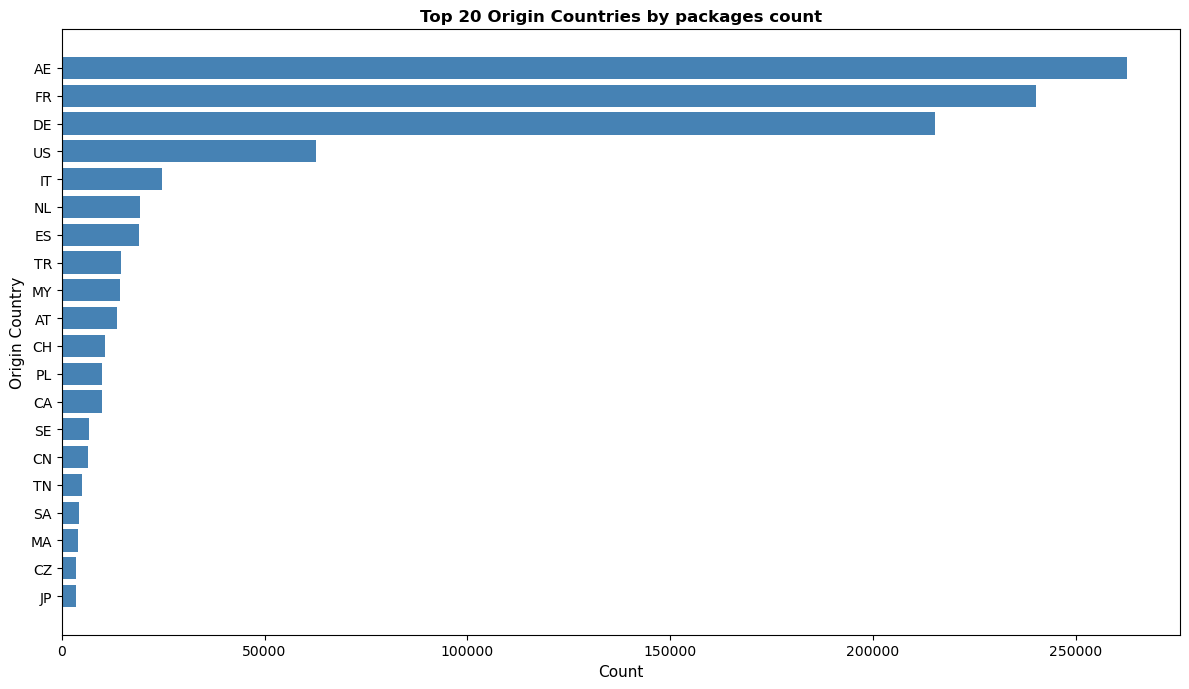

In [ ]:
origin_country_counts = parsed_packages_df['origin_country'].value_counts().head(20)
plt.figure(figsize=(12, 7))
plt.barh(origin_country_counts.index, origin_country_counts.values, color='steelblue')
plt.xlabel('Count', fontsize=11)
plt.ylabel('Origin Country', fontsize=11)
plt.title('Top 20 Origin Countries by packages count', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 2. for the parsed_receptacle_df

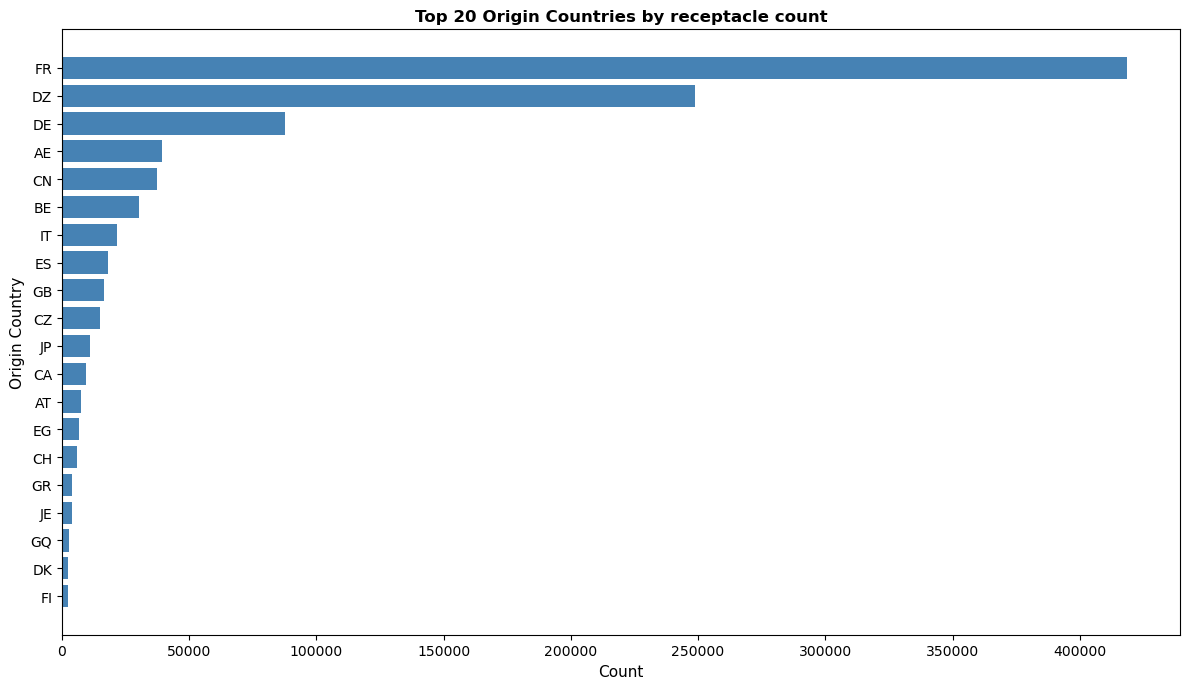

In [ ]:
origin_country_counts = parsed_receptacle_df['origin_country'].value_counts().head(20)
plt.figure(figsize=(12, 7))
plt.barh(origin_country_counts.index, origin_country_counts.values, color='steelblue')
plt.xlabel('Count', fontsize=11)
plt.ylabel('Origin Country', fontsize=11)
plt.title('Top 20 Origin Countries by receptacle count', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Visualiation of the service indicator

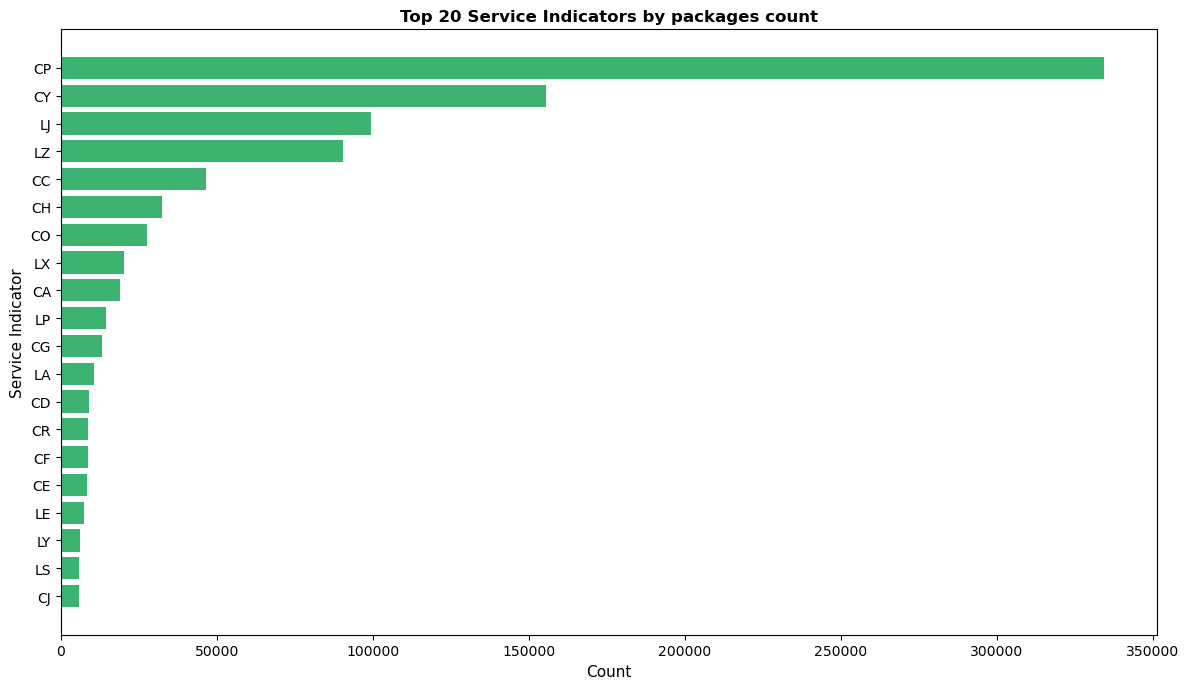

In [ ]:
service_indicator_count = parsed_packages_df['service_indicator'].value_counts().head(20)
plt.figure(figsize=(12, 7))
plt.barh(service_indicator_count.index, service_indicator_count.values, color='mediumseagreen')
plt.xlabel('Count', fontsize=11)
plt.ylabel('Service Indicator', fontsize=11)
plt.title('Top 20 Service Indicators by packages count', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Origin–Destination Flow Analysis

This section investigates the flow of receptacles and packages from origin countries to destination. We examine:
- packages count by origin country
- Top origin countries delivering to each destination
- Visual representation 

### 1. parsed_packages_df

In [ ]:
# packages count by origin country
origin_country_volume = parsed_packages_df['origin_country'].value_counts()
print("\n--- Packages count by Origin Country ---")
print(origin_country_volume.head(15))

# Create origin_country × destination matrix
flow_matrix = pd.crosstab(parsed_packages_df['origin_country'], 
                           parsed_packages_df['destination_country'])

# Keep only top 10 origin countries and top 10 destination countries for readability
top_origins = parsed_packages_df['origin_country'].value_counts().head(10).index
top_arrivals = parsed_packages_df['destination_country'].value_counts().head(10).index

flow_matrix_top = flow_matrix.loc[top_origins, top_arrivals]

print("\n--- Origin Country × destination Country (Top 10 × Top 10) ---")
print(flow_matrix_top)



--- Packages count by Origin Country ---
origin_country
AE    262591
FR    240310
DE    215237
US     62645
IT     24752
NL     19355
ES     19016
TR     14722
MY     14439
AT     13588
CH     10590
PL      9981
CA      9828
SE      6593
CN      6347
Name: count, dtype: int64

--- Origin Country × destination Country (Top 10 × Top 10) ---
destination_country      DZ
origin_country             
AE                   262591
FR                   240310
DE                   215237
US                    62645
IT                    24752
NL                    19355
ES                    19016
TR                    14722
MY                    14439
AT                    13588


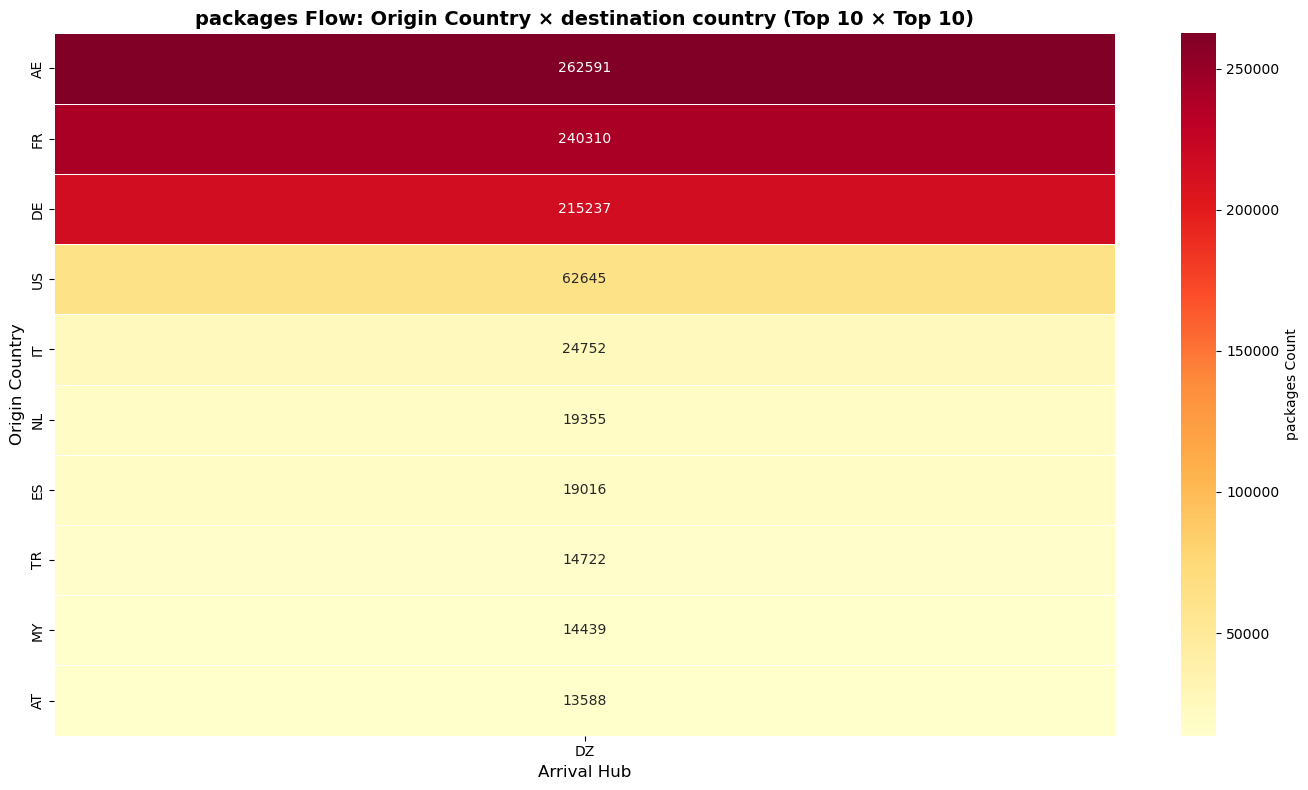

In [ ]:
# Visualize origin × destination country flow
plt.figure(figsize=(14, 8))
sns.heatmap(flow_matrix_top, cmap='YlOrRd', annot=True, fmt='d', 
            cbar_kws={'label': 'packages Count'}, linewidths=0.5)
plt.title('packages Flow: Origin Country × destination country (Top 10 × Top 10)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Arrival Hub', fontsize=12)
plt.ylabel('Origin Country', fontsize=12)
plt.tight_layout()
plt.show()


### 2. parsed_receptacle_df

In [ ]:
# receptacle count by origin country
origin_country_receptacle_volume = parsed_receptacle_df['origin_country'].value_counts()
print("\n--- Receptacle count by Origin Country ---")
print(origin_country_receptacle_volume.head(15))

destination__receptacle_volume=parsed_receptacle_df['destination_country'].value_counts()
print("\n--- Receptacle count by destination ---")
print(destination__receptacle_volume.head(15))

# Create origin_country × destination matrix
receptacle_flow_matrix = pd.crosstab(parsed_receptacle_df['origin_country'], 
                           parsed_receptacle_df['destination_country'])

# Keep only top 10 origin countries and top 10 destination countries for readability
receptacle_top_origins = parsed_receptacle_df['origin_country'].value_counts().head(10).index
receptacle_top_arrivals = parsed_receptacle_df['destination_country'].value_counts().head(10).index

receptacle_flow_matrix_top = receptacle_flow_matrix.loc[receptacle_top_origins, receptacle_top_arrivals]

print("\n--- Origin Country × destination Country (Top 10 × Top 10) ---")
print(receptacle_flow_matrix_top)



--- Receptacle count by Origin Country ---
origin_country
FR    418448
DZ    248737
DE     87816
AE     39269
CN     37546
BE     30424
IT     21575
ES     17927
GB     16591
CZ     15006
JP     11110
CA      9282
AT      7410
EG      6852
CH      5755
Name: count, dtype: int64

--- Receptacle count by destination ---
destination_country
DZ    748923
FR    126075
CA     22430
DE     12809
US      7944
IT      6079
GB      5895
ES      5713
TR      4730
CH      4707
BE      4126
TN      4069
AE      4056
CN      3339
PL      3095
Name: count, dtype: int64

--- Origin Country × destination Country (Top 10 × Top 10) ---
destination_country      DZ      FR     CA     DE    US    IT    GB    ES  \
origin_country                                                              
FR                   417446       8      2      0    11     0     0     3   
DZ                        5  126066  22428  12807  7933  6079  5895  5706   
DE                    87730       0      0      0     0     0     

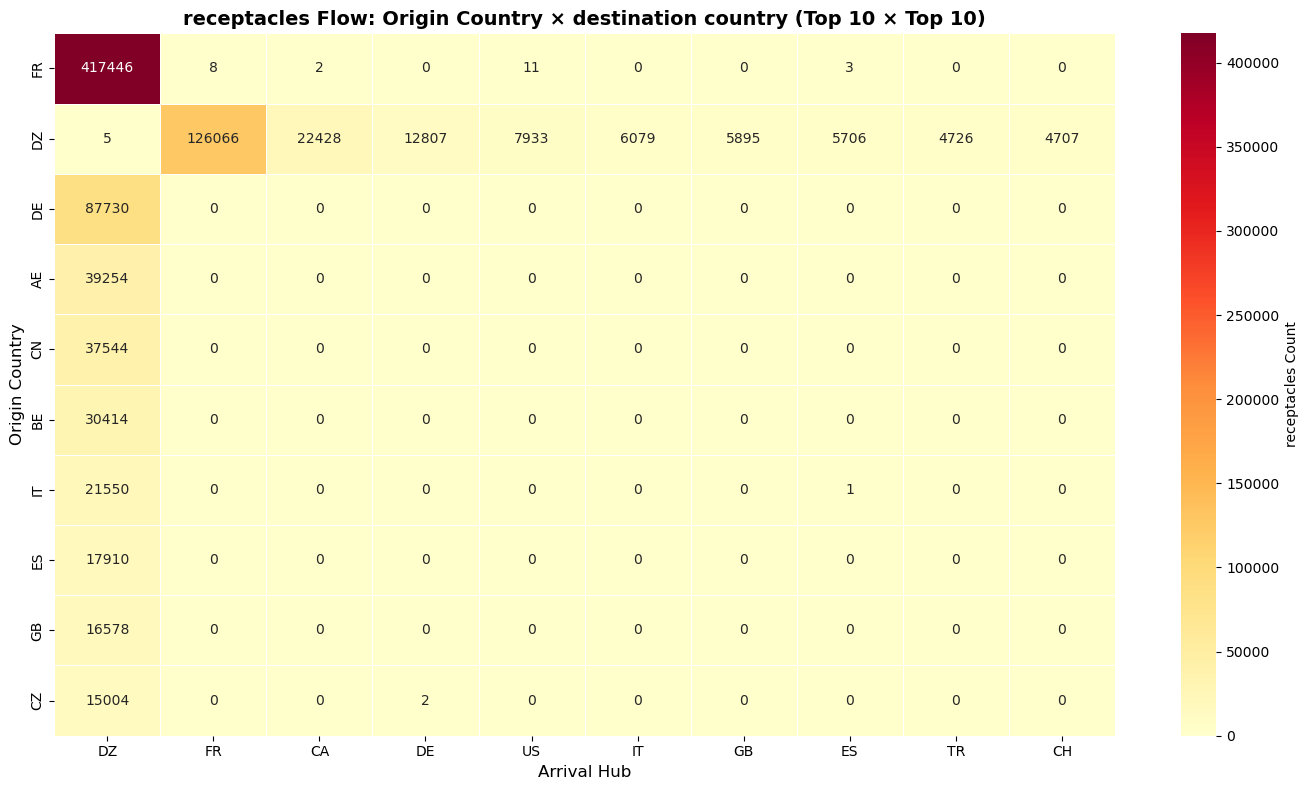

In [ ]:
# Visualize origin × destination country flow
plt.figure(figsize=(14, 8))
sns.heatmap(receptacle_flow_matrix_top, cmap='YlOrRd', annot=True, fmt='d', 
            cbar_kws={'label': 'receptacles Count'}, linewidths=0.5)
plt.title('receptacles Flow: Origin Country × destination country (Top 10 × Top 10)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Arrival Hub', fontsize=12)
plt.ylabel('Origin Country', fontsize=12)
plt.tight_layout()
plt.show()


### create pairs (origin, destination) for more detailed analysis

In [ ]:
parsed_packages_df['origin_destination'] = parsed_packages_df['origin_country'] + '_' + parsed_packages_df['destination_country']
parsed_receptacle_df['origin_destination'] = parsed_receptacle_df['origin_country'] + '_' + parsed_receptacle_df['destination_country']


listing the obtained values 

In [ ]:
print('(origin_destination) pairs obtained for ')
print("\nfor parsed_packages_df :")
print("\nNumber of unique values", parsed_packages_df['origin_destination'].nunique())
print("\nValues : ")
print(parsed_packages_df['origin_destination'].unique())
print("\nfor parsed_receptacles_df :")
print("\nNumber of unique values", parsed_receptacle_df['origin_destination'].nunique())
print("\nValues : ")
print(parsed_receptacle_df['origin_destination'].unique())


(origin_destination) pairs obtained for 

for parsed_packages_df :

Number of unique values 64

Values : 
['FR_DZ' 'CH_DZ' 'MA_DZ' 'US_DZ' 'BE_DZ' 'TG_DZ' 'PK_DZ' 'RU_DZ' 'GR_DZ'
 'JE_DZ' 'CI_DZ' 'PT_DZ' 'TN_DZ' 'AT_DZ' 'AR_DZ' 'KR_DZ' 'DE_DZ' 'JP_DZ'
 'TR_DZ' 'OM_DZ' 'AZ_DZ' 'NL_DZ' 'UA_DZ' 'MD_DZ' 'AE_DZ' 'ES_DZ' 'BG_DZ'
 'GB_DZ' 'IT_DZ' 'SE_DZ' 'CA_DZ' 'NG_DZ' 'HU_DZ' 'NZ_DZ' 'AM_DZ' 'DK_DZ'
 'CZ_DZ' 'SA_DZ' 'FI_DZ' 'CN_DZ' 'LT_DZ' 'HK_DZ' 'TH_DZ' 'ID_DZ' 'IE_DZ'
 'PS_DZ' 'DJ_DZ' 'BJ_DZ' 'GE_DZ' 'BH_DZ' 'MR_DZ' 'IQ_DZ' 'LB_DZ' 'CU_DZ'
 'VN_DZ' 'PL_DZ' 'QA_DZ' 'JO_DZ' 'MY_DZ' 'MV_DZ' 'MU_DZ' 'SG_DZ' 'KG_DZ'
 'EG_DZ']

for parsed_receptacles_df :

Number of unique values 174

Values : 
['AE_DZ' 'AE_MU' 'AE_NE' 'AE_TN' 'AM_DZ' 'AR_DZ' 'AT_DZ' 'AU_NL' 'AU_AE'
 'AZ_DZ' 'AZ_KZ' 'BE_AU' 'BE_CL' 'BE_DZ' 'BE_AR' 'BF_FR' 'BG_DZ' 'BH_DZ'
 'BJ_DZ' 'BY_DZ' 'CA_DZ' 'CG_DZ' 'CH_DZ' 'CH_JP' 'CI_DZ' 'CM_DZ' 'CN_AR'
 'CN_DZ' 'CR_DZ' 'CR_ES' 'CU_DZ' 'CZ_DE' 'CZ_DZ' 'DE_DZ' 'DE_KG' 'DE_LY'
 'DE_ML' 'DE

### visualization of obtained results 

### 1. parsed_packages_df

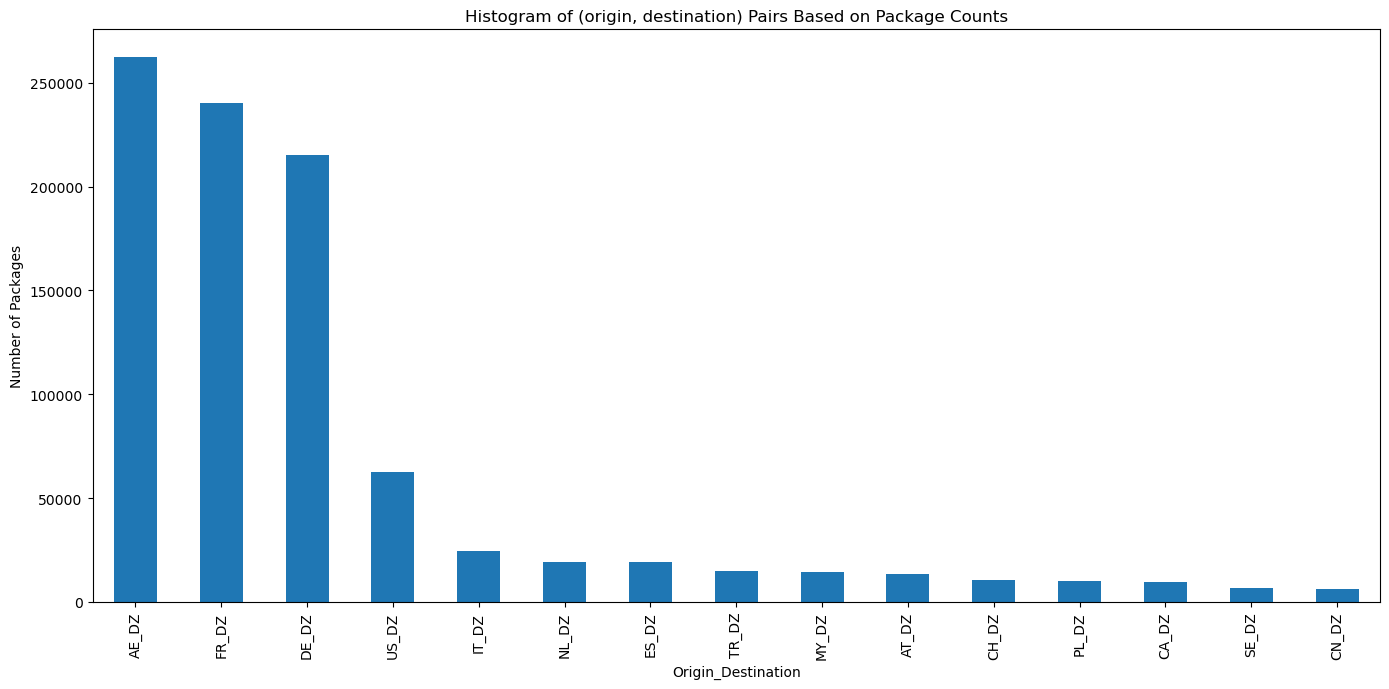

In [ ]:
origin_dest_counts = parsed_packages_df['origin_destination'].value_counts()
top_origin_dest_counts= origin_dest_counts.head(15)
plt.figure(figsize=(14, 7))
top_origin_dest_counts.plot(kind='bar')
plt.title('Histogram of (origin, destination) Pairs Based on Package Counts')
plt.xlabel('Origin_Destination')
plt.ylabel('Number of Packages')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



### 2. parsed_receptacle_df

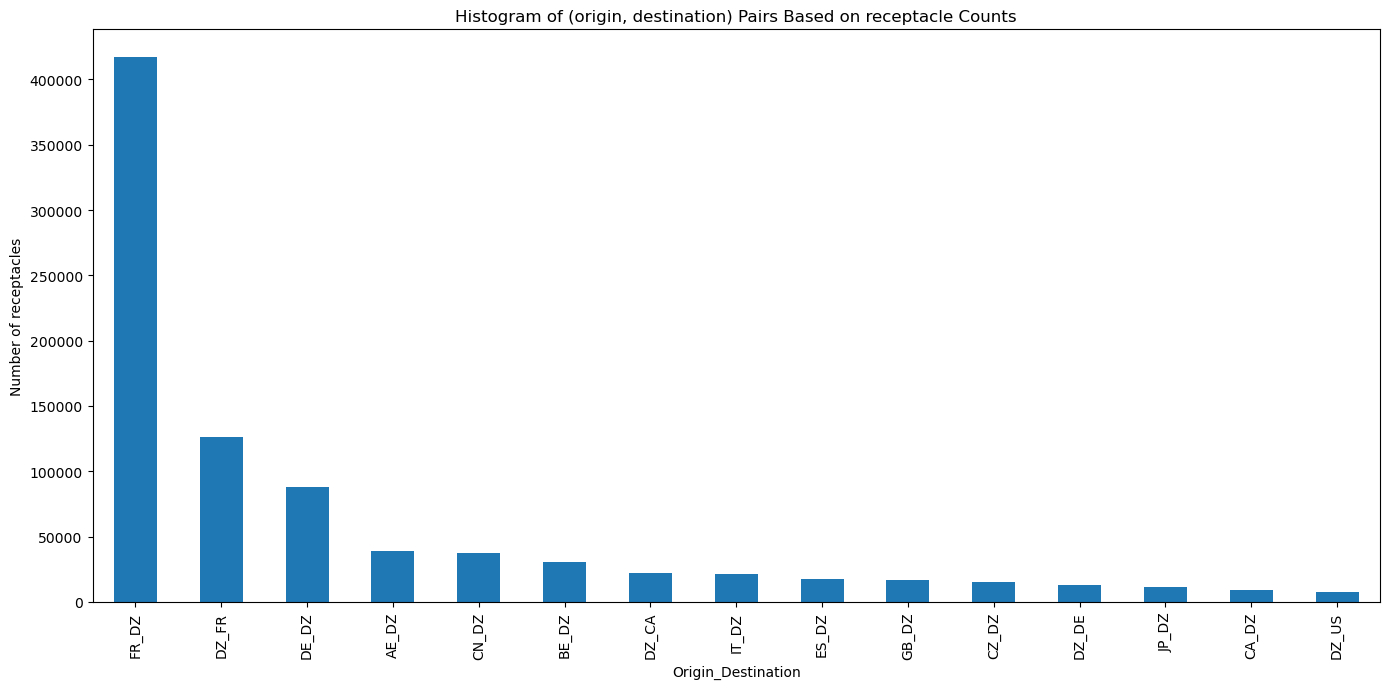

In [ ]:
origin_dest_counts = parsed_receptacle_df['origin_destination'].value_counts()
top_origin_dest_counts = origin_dest_counts.head(15)

plt.figure(figsize=(14, 7))
top_origin_dest_counts.plot(kind='bar')
plt.title('Histogram of (origin, destination) Pairs Based on receptacle Counts')
plt.xlabel('Origin_Destination')
plt.ylabel('Number of receptacles')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## origin_destination X etablissments analysis 

## 1. current etablissment 

### a. parsed_packages_df

C:\Users\djame\AppData\Local\Temp\ipykernel_22404\1253458664.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


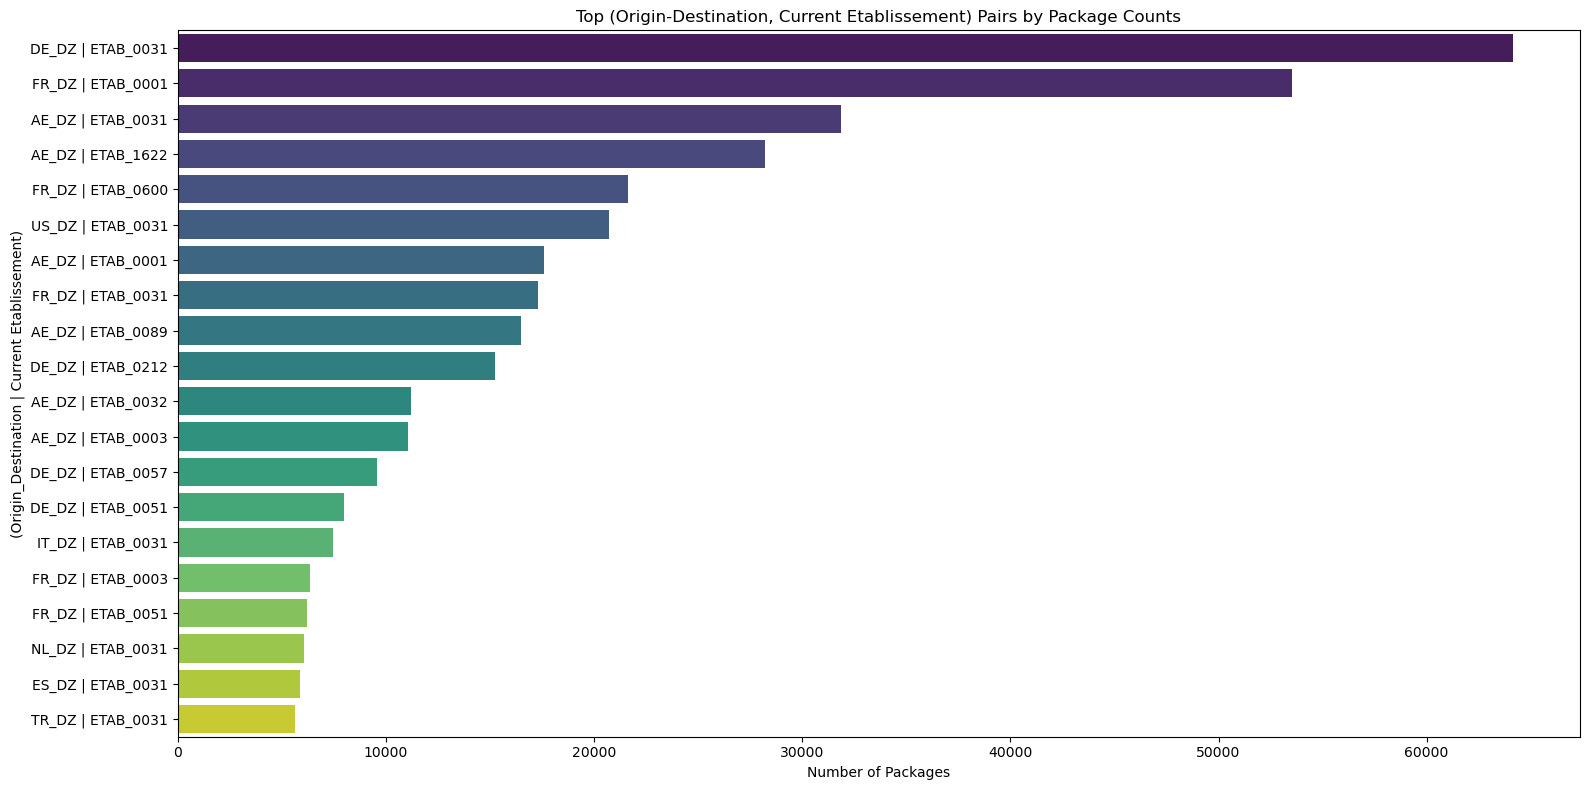

In [ ]:
# For parsed_packages_df: visualize the histogram of counts by (origin_destination, etablissement_postal) pairs

# First, select top N most common (origin_destination, etablissement_postal) pairs for clarity
pair_counts_current = parsed_packages_df.groupby(['origin_destination', 'etablissement_postal']).size().reset_index(name='count')

# Sort and keep only top N pairs (by count)
top_n = 20
top_pairs_current = pair_counts_current.sort_values('count', ascending=False).head(top_n)

plt.figure(figsize=(16, 8))
sns.barplot(
    data=top_pairs_current,
    x='count',
    y=top_pairs_current.apply(lambda x: f"{x['origin_destination']} | {x['etablissement_postal']}", axis=1),
    palette='viridis'
)
plt.title('Top (Origin-Destination, Current Etablissement) Pairs by Package Counts')
plt.xlabel('Number of Packages')
plt.ylabel('(Origin_Destination | Current Etablissement)')
plt.tight_layout()
plt.show()


### b. parsed_receptacle_df

C:\Users\djame\AppData\Local\Temp\ipykernel_22404\2341665696.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


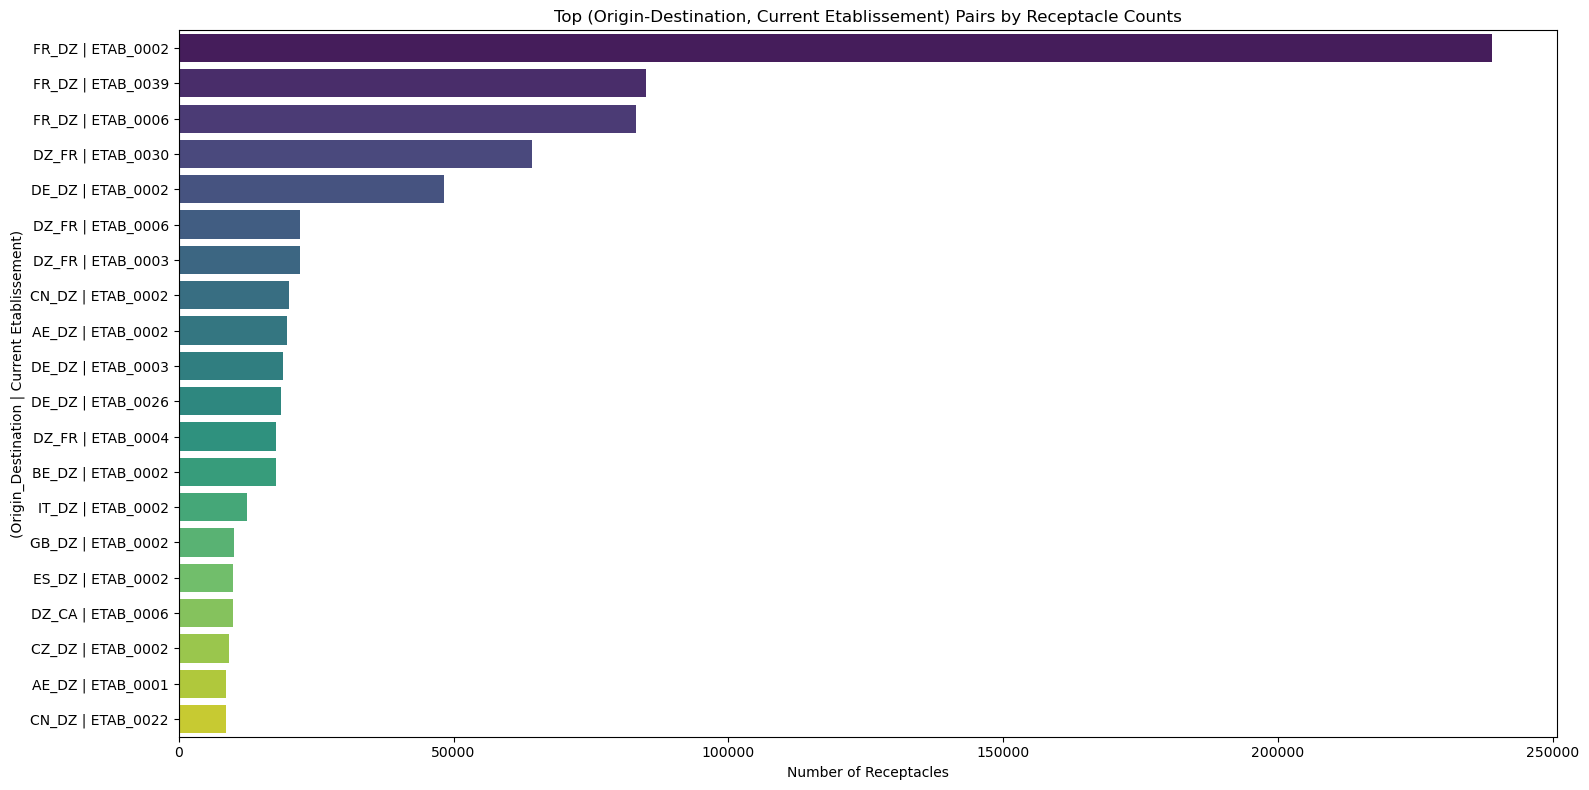

In [ ]:
# For parsed_receptacle_df: visualize the histogram of counts by (origin_destination, etablissement_postal) pairs

# First, select top N most common (origin_destination, etablissement_postal) pairs for clarity
pair_counts_current_receptacle = parsed_receptacle_df.groupby(['origin_destination', 'etablissement_postal']).size().reset_index(name='count')

# Sort and keep only top N pairs (by count)
top_n = 20
top_pairs_current_receptacle = pair_counts_current_receptacle.sort_values('count', ascending=False).head(top_n)

plt.figure(figsize=(16, 8))
sns.barplot(
    data=top_pairs_current_receptacle,
    x='count',
    y=top_pairs_current_receptacle.apply(lambda x: f"{x['origin_destination']} | {x['etablissement_postal']}", axis=1),
    palette='viridis'
)
plt.title('Top (Origin-Destination, Current Etablissement) Pairs by Receptacle Counts')
plt.xlabel('Number of Receptacles')
plt.ylabel('(Origin_Destination | Current Etablissement)')
plt.tight_layout()
plt.show()


we can see that the ETAB0002 is dominating and we remark that when the destination is DZ
we'll try to confirm that by taking into consideration the destination only


C:\Users\djame\AppData\Local\Temp\ipykernel_22404\146782092.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


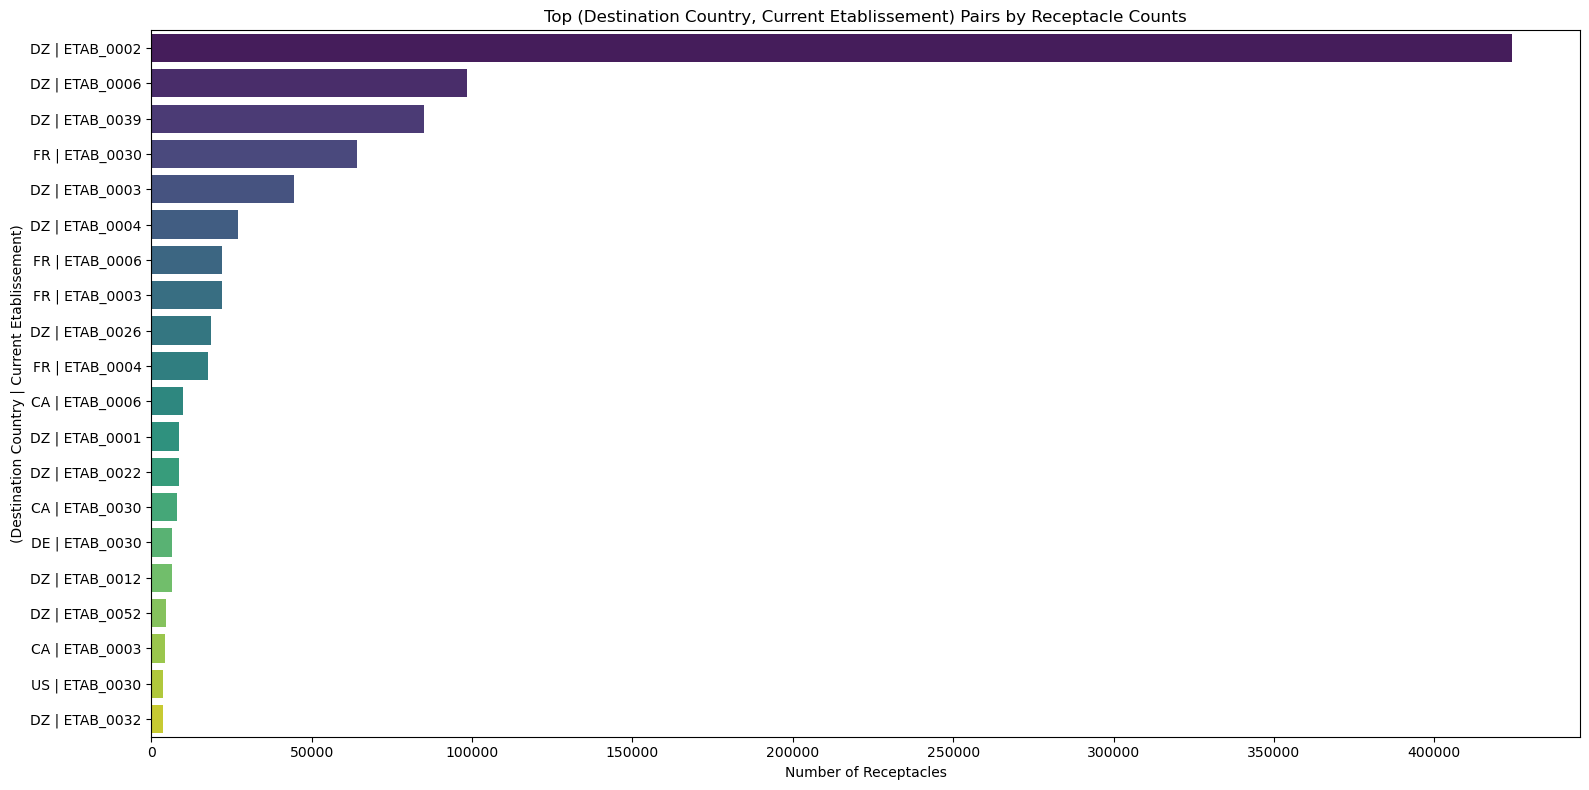

In [ ]:
# For parsed_receptacle_df: visualize the histogram of counts by (destination_country, etablissement_postal) pairs

# First, select top N most common (destination_country, etablissement_postal) pairs for clarity
pair_counts_dest_receptacle = parsed_receptacle_df.groupby(['destination_country', 'etablissement_postal']).size().reset_index(name='count')

# Sort and keep only top N pairs (by count)
top_n = 20
top_pairs_dest_receptacle = pair_counts_dest_receptacle.sort_values('count', ascending=False).head(top_n)

plt.figure(figsize=(16, 8))
sns.barplot(
    data=top_pairs_dest_receptacle,
    x='count',
    y=top_pairs_dest_receptacle.apply(lambda x: f"{x['destination_country']} | {x['etablissement_postal']}", axis=1),
    palette='viridis'
)
plt.title('Top (Destination Country, Current Etablissement) Pairs by Receptacle Counts')
plt.xlabel('Number of Receptacles')
plt.ylabel('(Destination Country | Current Etablissement)')
plt.tight_layout()
plt.show()


### This is to test the origin 

C:\Users\djame\AppData\Local\Temp\ipykernel_22404\1166783672.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


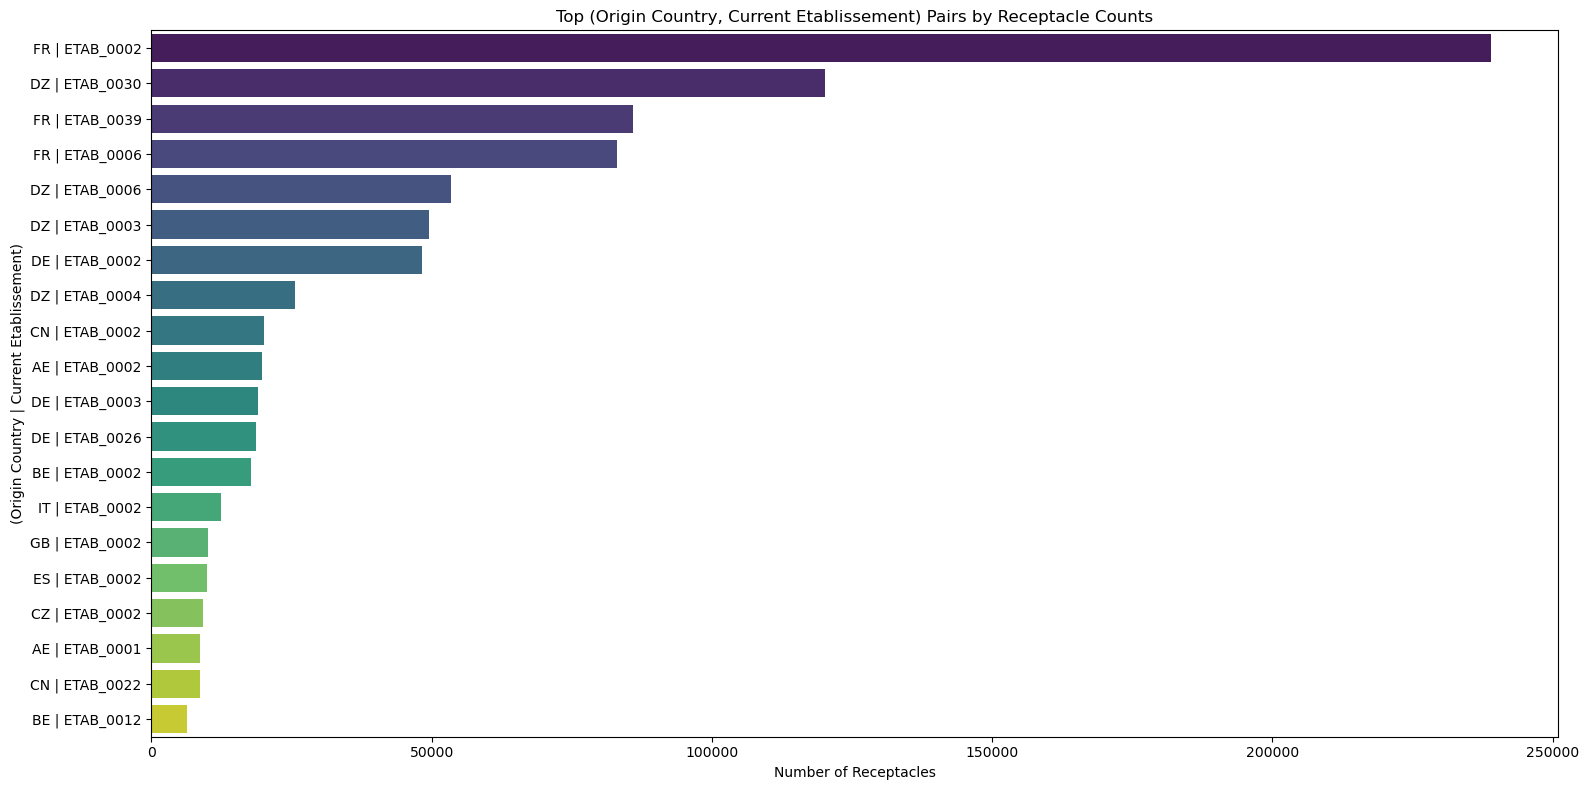

In [ ]:
# For parsed_receptacle_df: visualize the histogram of counts by (origin_country, etablissement_postal) pairs

# First, select top N most common (origin_country, etablissement_postal) pairs for clarity
pair_counts_origin_receptacle = parsed_receptacle_df.groupby(['origin_country', 'etablissement_postal']).size().reset_index(name='count')

# Sort and keep only top N pairs (by count)
top_n = 20
top_pairs_origin_receptacle = pair_counts_origin_receptacle.sort_values('count', ascending=False).head(top_n)

plt.figure(figsize=(16, 8))
sns.barplot(
    data=top_pairs_origin_receptacle,
    x='count',
    y=top_pairs_origin_receptacle.apply(lambda x: f"{x['origin_country']} | {x['etablissement_postal']}", axis=1),
    palette='viridis'
)
plt.title('Top (Origin Country, Current Etablissement) Pairs by Receptacle Counts')
plt.xlabel('Number of Receptacles')
plt.ylabel('(Origin Country | Current Etablissement)')
plt.tight_layout()
plt.show()


most of the values with ETAB0002 values are european countries in addition to AE and China(CN)

## 2. Next etablissement

### a. parsed_packages_df

C:\Users\djame\AppData\Local\Temp\ipykernel_22404\2809534773.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


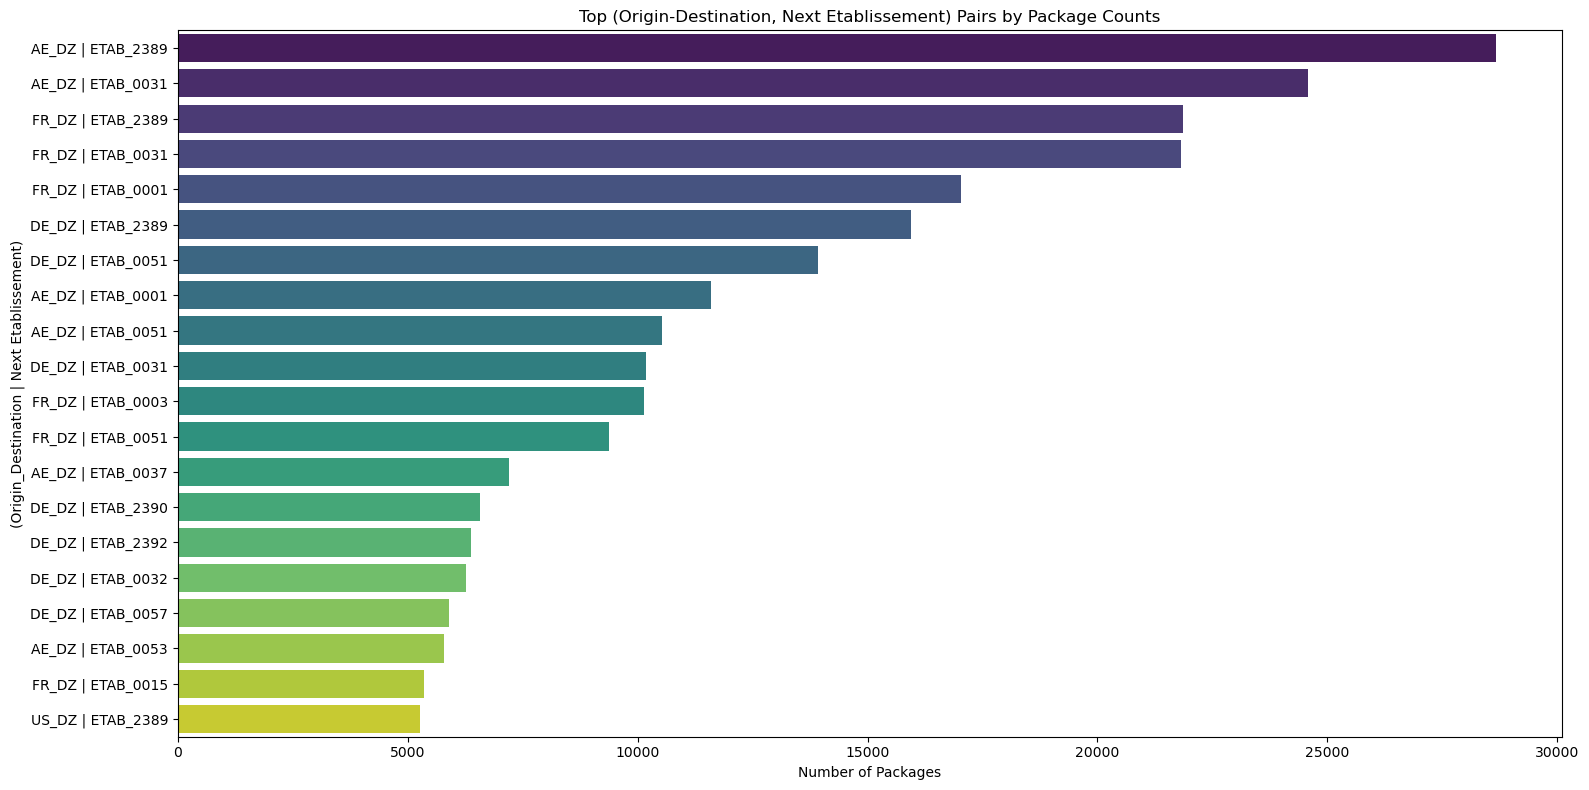

In [ ]:
# For parsed_packages_df: visualize the histogram of counts by (origin_destination, next_etablissement_postal)

# First, select top N most common (origin_destination, next_etablissement_postal) pairs for clarity
pair_counts = parsed_packages_df.groupby(['origin_destination', 'next_etablissement_postal']).size().reset_index(name='count')

# Sort and keep only top N pairs (by count)
top_n = 20
top_pairs = pair_counts.sort_values('count', ascending=False).head(top_n)

plt.figure(figsize=(16, 8))
sns.barplot(
    data=top_pairs,
    x='count',
    y=top_pairs.apply(lambda x: f"{x['origin_destination']} | {x['next_etablissement_postal']}", axis=1),
    palette='viridis'
)
plt.title('Top (Origin-Destination, Next Etablissement) Pairs by Package Counts')
plt.xlabel('Number of Packages')
plt.ylabel('(Origin_Destination | Next Etablissement)')
plt.tight_layout()
plt.show()


### b. parsed_receptacle_df

C:\Users\djame\AppData\Local\Temp\ipykernel_22404\1683771313.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


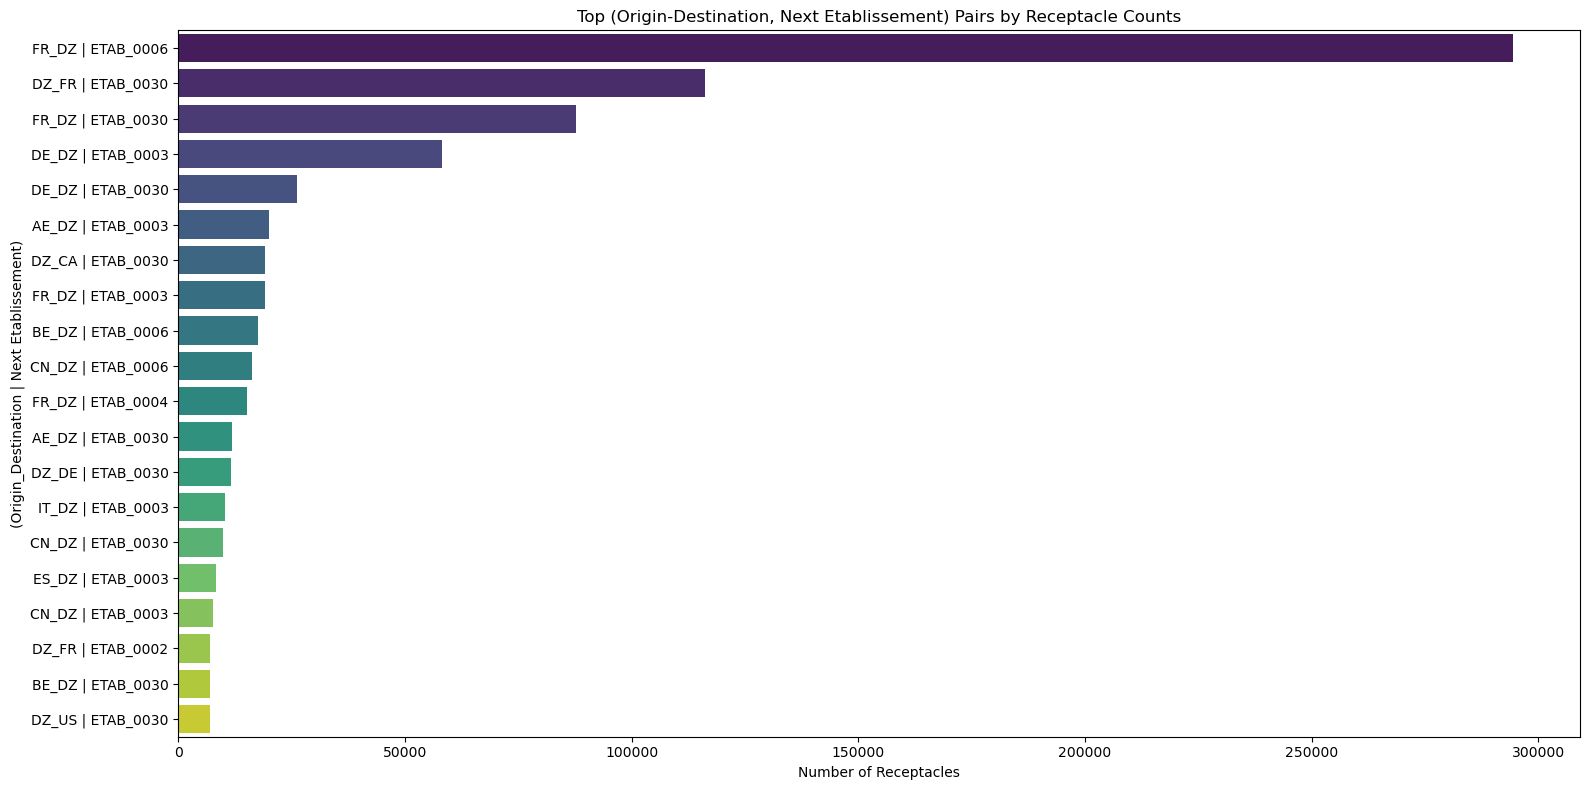

In [ ]:
# For parsed_receptacle_df: visualize the histogram of counts by (origin_destination, next_etablissement_postal)

# First, select top N most common (origin_destination, next_etablissement_postal) pairs for clarity
pair_counts_recept = parsed_receptacle_df.groupby(['origin_destination', 'next_etablissement_postal']).size().reset_index(name='count')

# Sort and keep only top N pairs (by count)
top_n = 20
top_pairs_recept = pair_counts_recept.sort_values('count', ascending=False).head(top_n)

plt.figure(figsize=(16, 8))
sns.barplot(
    data=top_pairs_recept,
    x='count',
    y=top_pairs_recept.apply(lambda x: f"{x['origin_destination']} | {x['next_etablissement_postal']}", axis=1),
    palette='viridis'
)
plt.title('Top (Origin-Destination, Next Etablissement) Pairs by Receptacle Counts')
plt.xlabel('Number of Receptacles')
plt.ylabel('(Origin_Destination | Next Etablissement)')
plt.tight_layout()
plt.show()



Do for origin and for destination separately

C:\Users\djame\AppData\Local\Temp\ipykernel_22404\1050675875.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


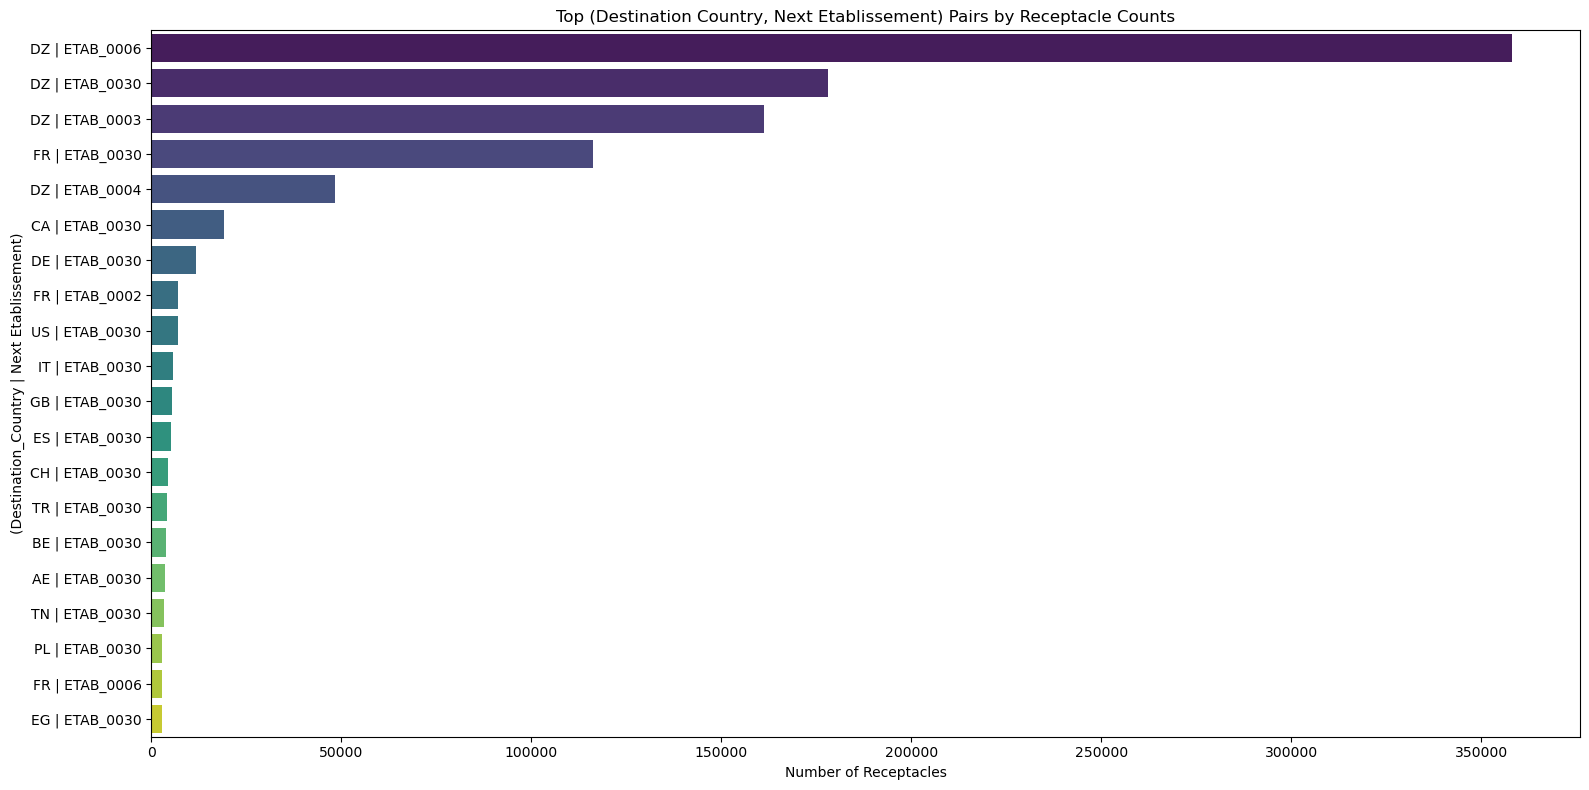

In [ ]:

# For parsed_receptacle_df: visualize the histogram of counts by destination_country and next_etablissement_postal

# First, select top N most common (destination_country, next_etablissement_postal) pairs for clarity
pair_counts_dest = parsed_receptacle_df.groupby(['destination_country', 'next_etablissement_postal']).size().reset_index(name='count')

# Sort and keep only top N pairs (by count)
top_n = 20
top_pairs_dest = pair_counts_dest.sort_values('count', ascending=False).head(top_n)

plt.figure(figsize=(16, 8))
sns.barplot(
    data=top_pairs_dest,
    x='count',
    y=top_pairs_dest.apply(lambda x: f"{x['destination_country']} | {x['next_etablissement_postal']}", axis=1),
    palette='viridis'
)
plt.title('Top (Destination Country, Next Etablissement) Pairs by Receptacle Counts')
plt.xlabel('Number of Receptacles')
plt.ylabel('(Destination_Country | Next Etablissement)')
plt.tight_layout()
plt.show()


C:\Users\djame\AppData\Local\Temp\ipykernel_22404\170026808.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


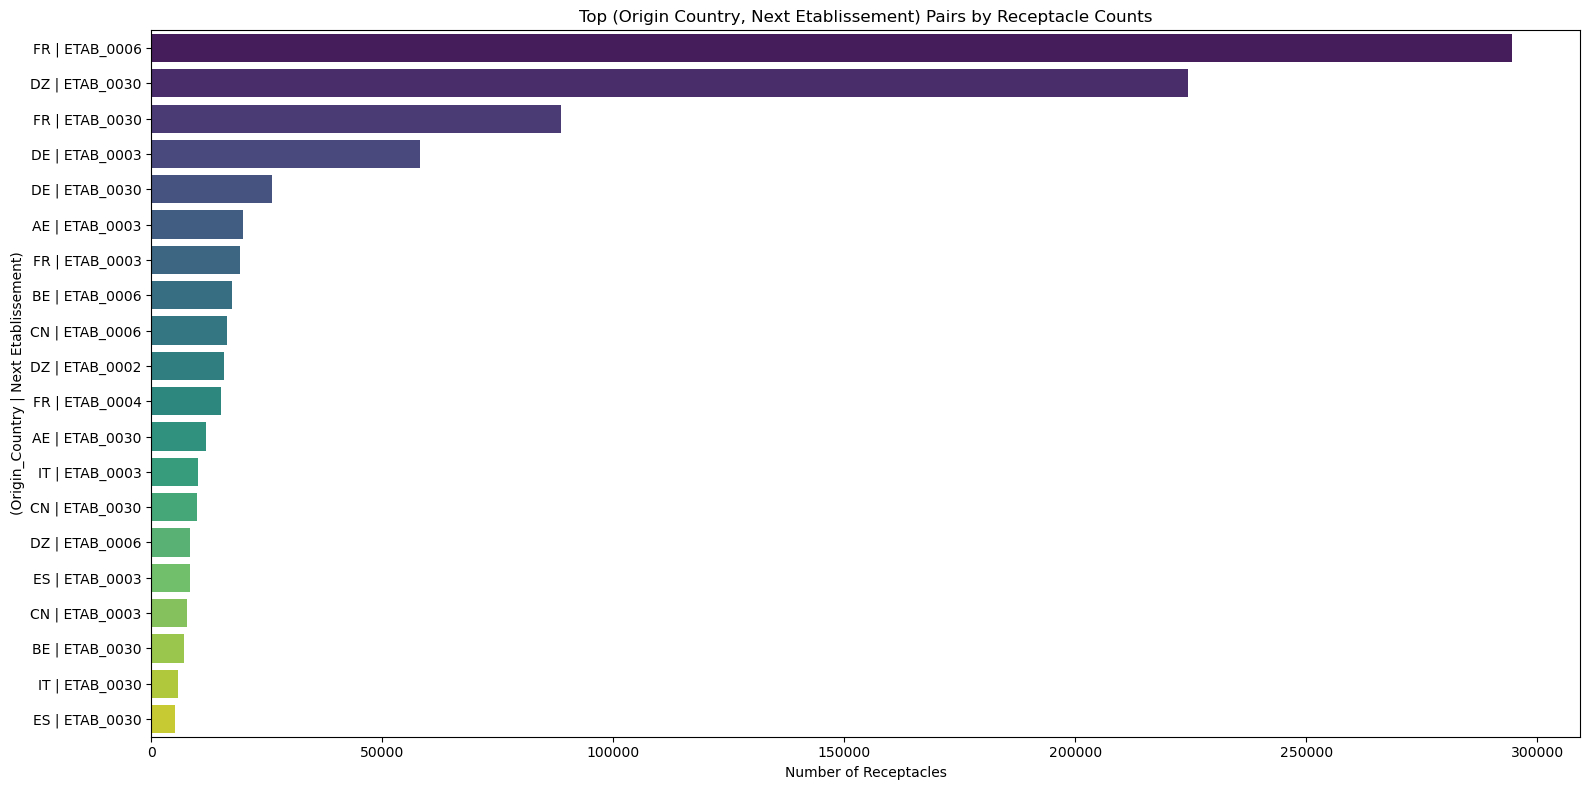

In [ ]:
# For parsed_receptacle_df: visualize the histogram of counts by origin_country and next_etablissement_postal

# First, select top N most common (origin_country, next_etablissement_postal) pairs for clarity
pair_counts_origin = parsed_receptacle_df.groupby(['origin_country', 'next_etablissement_postal']).size().reset_index(name='count')

# Sort and keep only top N pairs (by count)
top_n = 20
top_pairs_origin = pair_counts_origin.sort_values('count', ascending=False).head(top_n)

plt.figure(figsize=(16, 8))
sns.barplot(
    data=top_pairs_origin,
    x='count',
    y=top_pairs_origin.apply(lambda x: f"{x['origin_country']} | {x['next_etablissement_postal']}", axis=1),
    palette='viridis'
)
plt.title('Top (Origin Country, Next Etablissement) Pairs by Receptacle Counts')
plt.xlabel('Number of Receptacles')
plt.ylabel('(Origin_Country | Next Etablissement)')
plt.tight_layout()
plt.show()


from the analysis we can see that there are some etablissments that get congested forming a sort of loop (ETAB0030, ETAB0002, ETAB0006)

### Time analysis regarding origin

### 1. parsed_packages_df

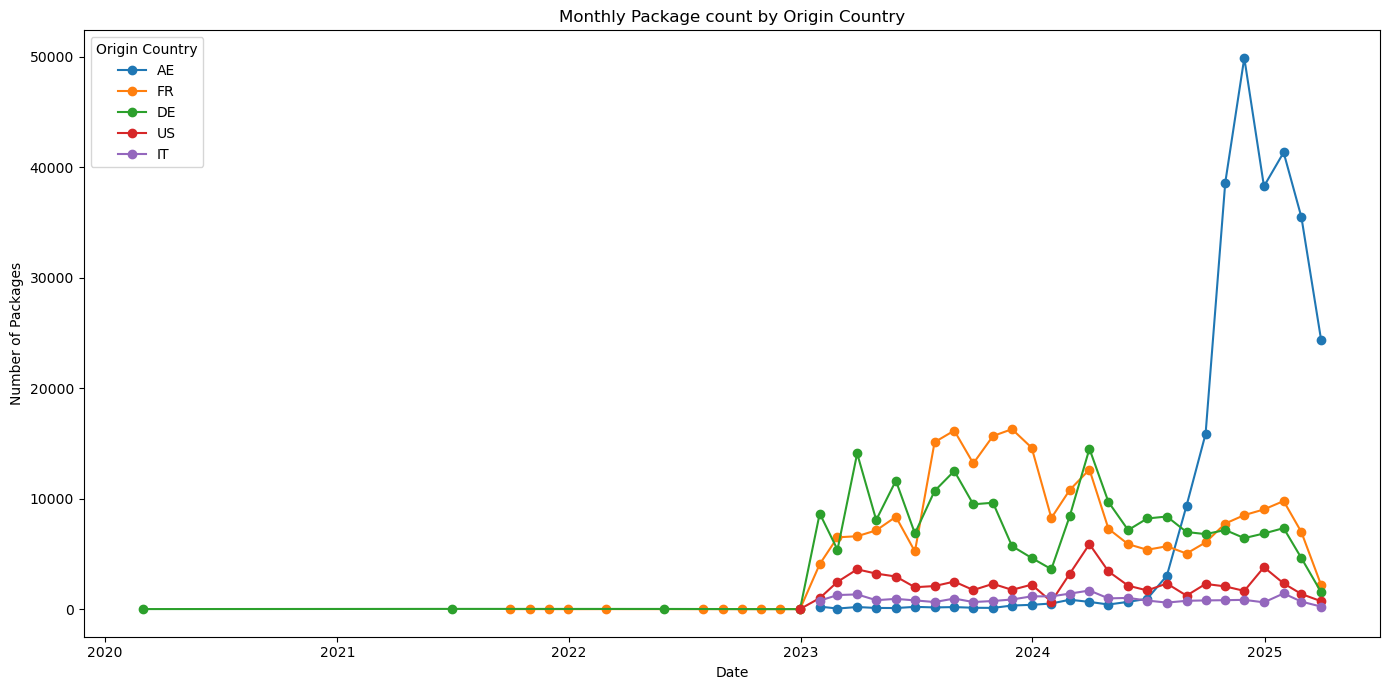

In [ ]:
# Group the parsed_packages_df by date and origin_country to count packages per month per origin country
parsed_packages_df['date'] = pd.to_datetime(parsed_packages_df['date'])

# Group by origin_country and resample by month
ts_by_origin = parsed_packages_df.groupby(['origin_country', pd.Grouper(key='date', freq='ME')])['MAILITM_FID'].count().reset_index()

# Choose top 5 origin countries by total count for plotting
top_origin = parsed_packages_df['origin_country'].value_counts().head(5).index
plt.figure(figsize=(14, 7))

for origin in top_origin:
    ts = ts_by_origin[ts_by_origin['origin_country'] == origin]
    plt.plot(ts['date'], ts['MAILITM_FID'], marker='o', label=origin)

plt.title('Monthly Package count by Origin Country')
plt.xlabel('Date')
plt.ylabel('Number of Packages')
plt.legend(title='Origin Country')
plt.tight_layout()
plt.show()


### 2. parsed_receptacle_df

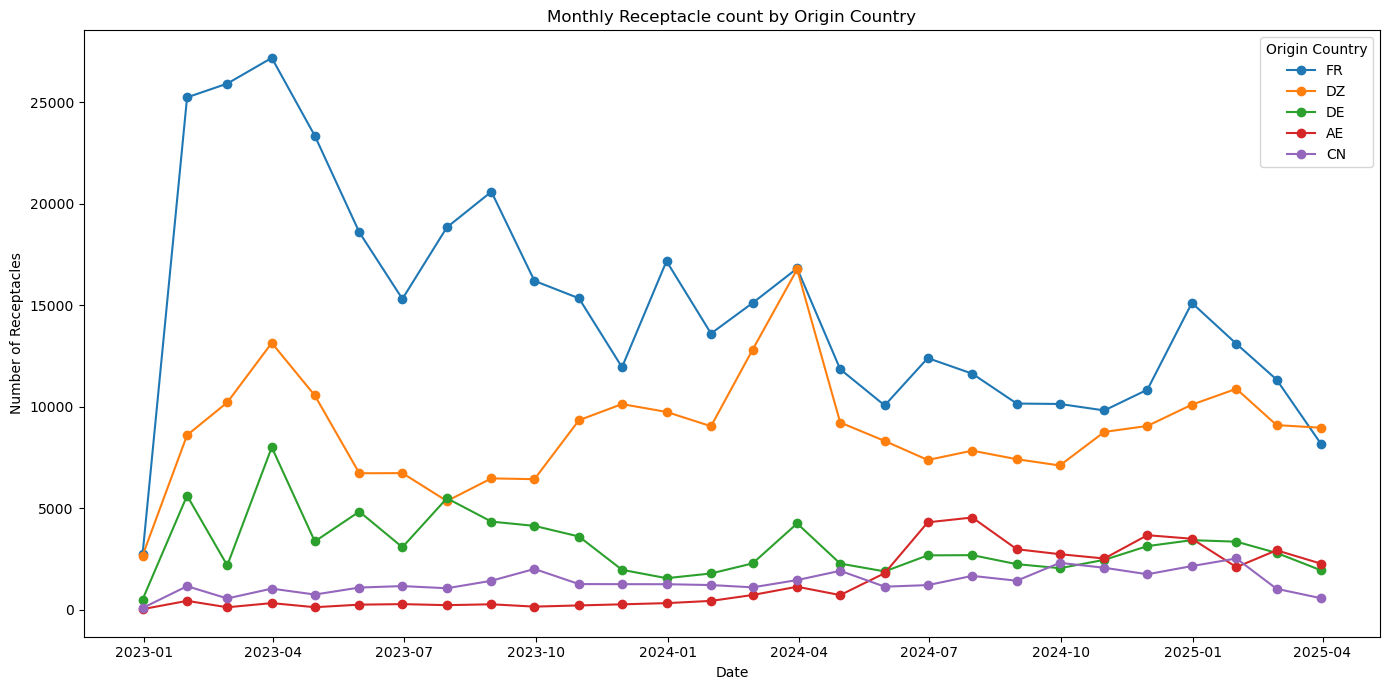

In [ ]:
# Group the parsed_receptacle_df by date and origin_country to count receptacles per month per origin country
parsed_receptacle_df['date'] = pd.to_datetime(parsed_receptacle_df['date'])

# Group by origin_country and resample by month
ts_by_origin_recept = parsed_receptacle_df.groupby(['origin_country', pd.Grouper(key='date', freq='ME')])['RECPTCL_FID'].count().reset_index()

# Choose top 5 origin countries by total count for plotting
top_origin_recept = parsed_receptacle_df['origin_country'].value_counts().head(5).index
plt.figure(figsize=(14, 7))

for origin in top_origin_recept:
    ts = ts_by_origin_recept[ts_by_origin_recept['origin_country'] == origin]
    plt.plot(ts['date'], ts['RECPTCL_FID'], marker='o', label=origin)

plt.title('Monthly Receptacle count by Origin Country')
plt.xlabel('Date')
plt.ylabel('Number of Receptacles')
plt.legend(title='Origin Country')
plt.tight_layout()
plt.show()


### Time analysis by destination

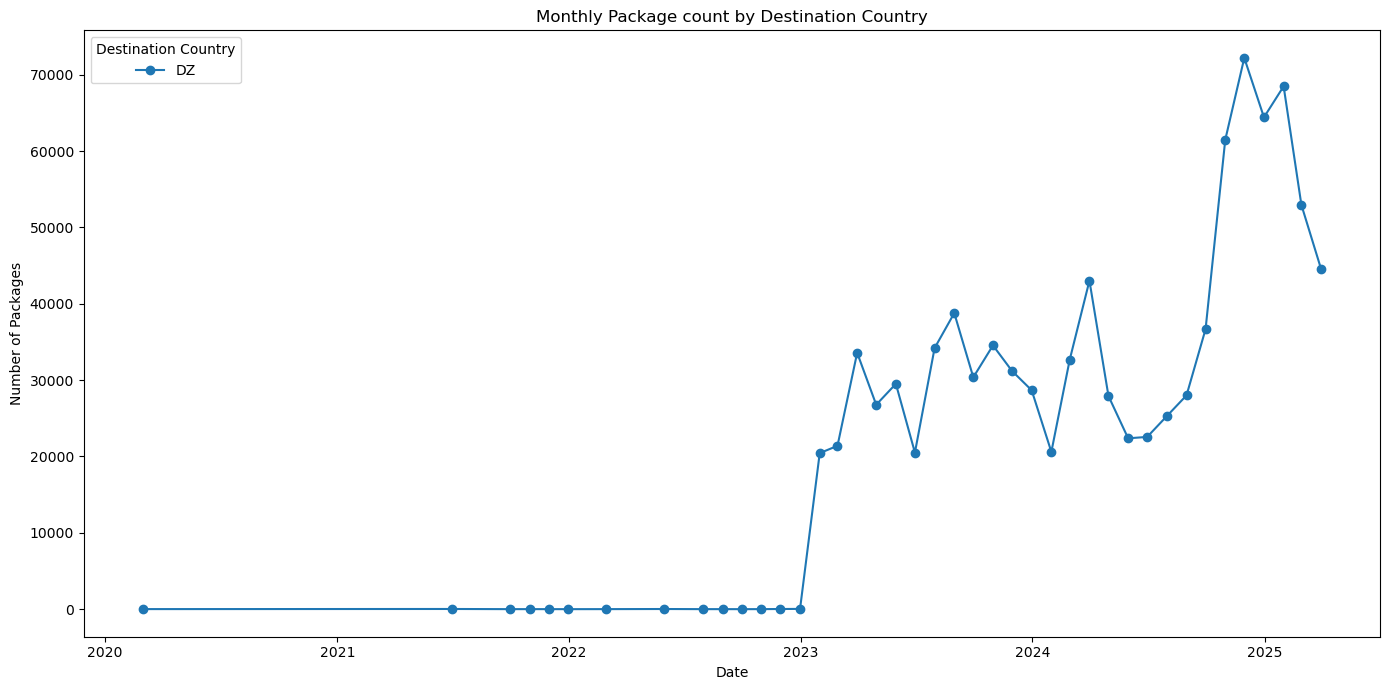

In [ ]:
# Group the parsed_packages_df by date and destination_country to count packages per month per destination country
parsed_packages_df['date'] = pd.to_datetime(parsed_packages_df['date'])

# Group by destination_country and resample by month
ts_by_dest = parsed_packages_df.groupby(['destination_country', pd.Grouper(key='date', freq='ME')])['MAILITM_FID'].count().reset_index()

# Choose top 5 destination countries by total count for plotting
top_dest = parsed_packages_df['destination_country'].value_counts().head(5).index
plt.figure(figsize=(14, 7))

for dest in top_dest:
    ts = ts_by_dest[ts_by_dest['destination_country'] == dest]
    plt.plot(ts['date'], ts['MAILITM_FID'], marker='o', label=dest)

plt.title('Monthly Package count by Destination Country')
plt.xlabel('Date')
plt.ylabel('Number of Packages')
plt.legend(title='Destination Country')
plt.tight_layout()
plt.show()


### 2. parsed_receptacle_df

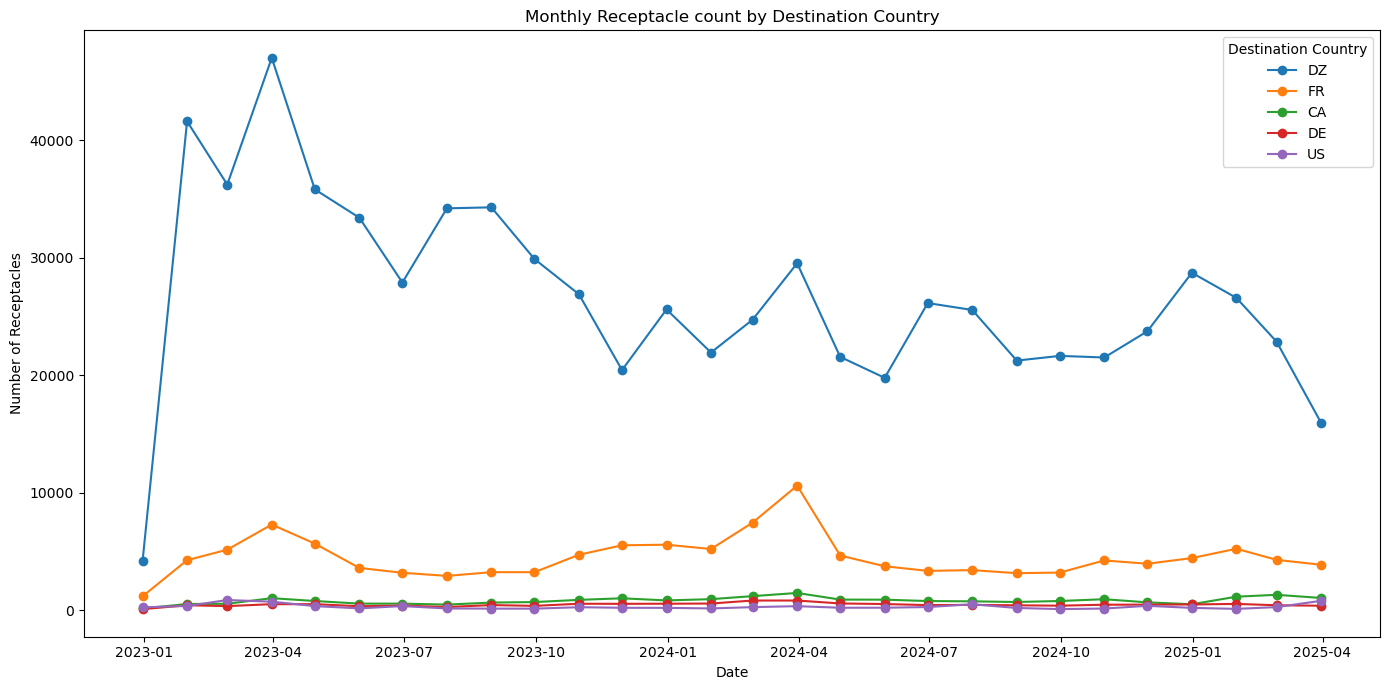

In [ ]:
# Group the parsed_receptacle_df by date and destination_country to count receptacles per month per destination country
parsed_receptacle_df['date'] = pd.to_datetime(parsed_receptacle_df['date'])

# Group by destination_country and resample by month 
ts_by_dest_recept = parsed_receptacle_df.groupby(['destination_country', pd.Grouper(key='date', freq='ME')])['RECPTCL_FID'].count().reset_index()

# Choose top 5 destination countries by total count for plotting
top_dest_recept = parsed_receptacle_df['destination_country'].value_counts().head(5).index
plt.figure(figsize=(14, 7))

for dest in top_dest_recept:
    ts = ts_by_dest_recept[ts_by_dest_recept['destination_country'] == dest]
    plt.plot(ts['date'], ts['RECPTCL_FID'], marker='o', label=dest)

plt.title('Monthly Receptacle count by Destination Country')
plt.xlabel('Date')
plt.ylabel('Number of Receptacles')
plt.legend(title='Destination Country')
plt.tight_layout()
plt.show()


## Creating additional features 
 1. 'flow_type' column with values: 'inbound' (to DZ), 'outbound' (from DZ), 'local' (DZ to DZ), otherwise 'other'

In [ ]:
import numpy as np

def get_flow_type(df):
    # Define the conditions
    conditions = [
        (df['destination_country'] == 'DZ') & (df['origin_country'] == 'DZ'), # local
        (df['destination_country'] == 'DZ'),                                # inbound
        (df['origin_country'] == 'DZ')                                     # outbound
    ]
    
    # Define the results for each condition
    choices = ['local', 'inbound', 'outbound']
    
    # Apply logic with 'other' as the default
    return np.select(conditions, choices, default='other')

# Apply to both DataFrames instantly
parsed_packages_df['flow_type'] = get_flow_type(parsed_packages_df)
parsed_receptacle_df['flow_type'] = get_flow_type(parsed_receptacle_df)

# Print counts
print("Flow type counts in parsed_packages_df:\n", parsed_packages_df['flow_type'].value_counts())
print("\nFlow type counts in parsed_receptacle_df:\n", parsed_receptacle_df['flow_type'].value_counts())

Flow type counts in parsed_packages_df:
 flow_type
inbound    973228
Name: count, dtype: int64

Flow type counts in parsed_receptacle_df:
 flow_type
inbound     748918
outbound    248732
other         1234
local            5
Name: count, dtype: int64


we can see that there are some values of flow type with the type "other"

In [ ]:
# Display the first 10 rows of origin_country and destination_country for flow_type 'other' in parsed_receptacle_df
print(parsed_receptacle_df.loc[parsed_receptacle_df['flow_type'] == 'other', ['origin_country', 'destination_country']].head(10))



      origin_country destination_country
39254             AE                  MU
39255             AE                  MU
39256             AE                  NE
39257             AE                  NE
39258             AE                  NE
39259             AE                  NE
39260             AE                  NE
39261             AE                  NE
39262             AE                  NE
39263             AE                  NE


## Analysis of the relation between the flow_type and the event_type

## 1. parsed_packages_df

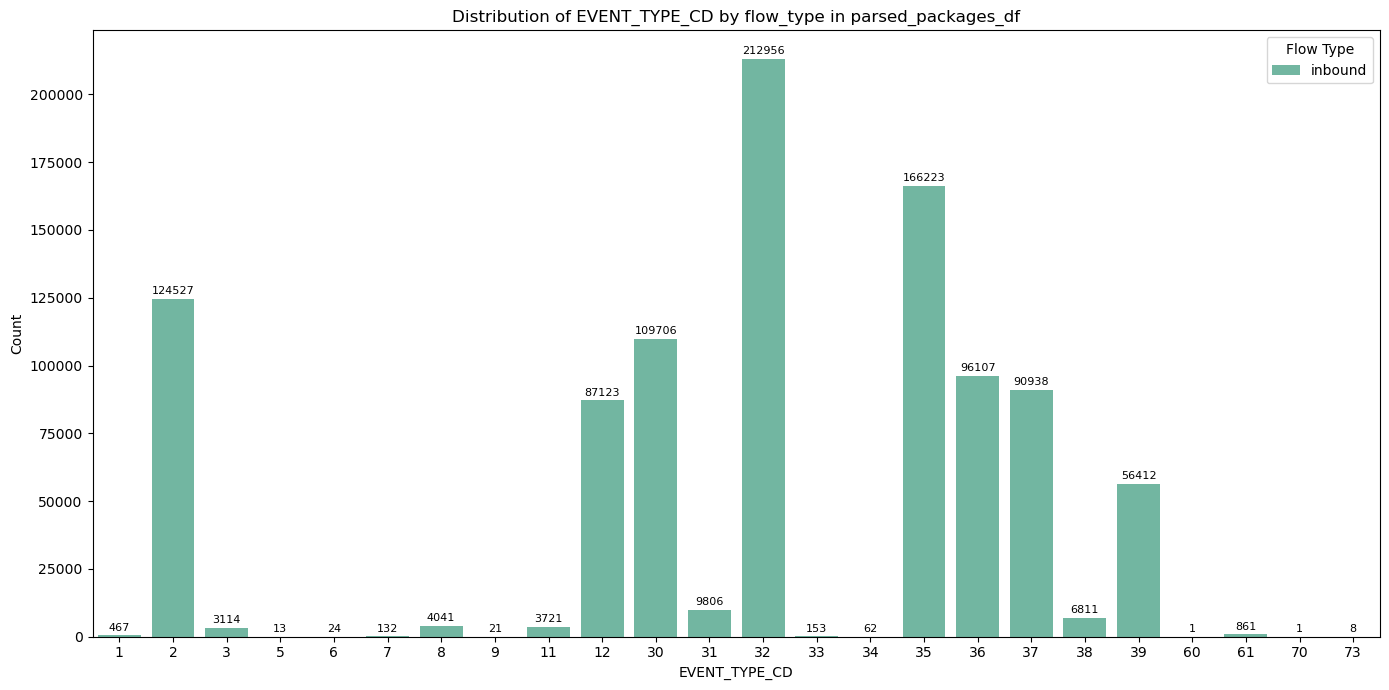

In [ ]:

# Analyse relation between flow_type and EVENT_TYPE_CD in parsed_packages_df

plt.figure(figsize=(14,7))
ax = sns.countplot(data=parsed_packages_df, x="EVENT_TYPE_CD", hue="flow_type", palette='Set2')
plt.title("Distribution of EVENT_TYPE_CD by flow_type in parsed_packages_df")
plt.xlabel("EVENT_TYPE_CD")
plt.ylabel("Count")
plt.legend(title="Flow Type")
plt.tight_layout()
for c in ax.containers:
    ax.bar_label(c, label_type='edge', fontsize=8, padding=2)
plt.show()



## 2. parsed_receptacle_df

In [ ]:
# For each flow_type, list the unique EVENT_TYPE_CD values and the most frequent EVENT_TYPE_CD value
for flow in parsed_receptacle_df['flow_type'].unique():
    event_types = parsed_receptacle_df.loc[parsed_receptacle_df['flow_type'] == flow, 'EVENT_TYPE_CD'].unique()
    most_common_event_type = parsed_receptacle_df.loc[parsed_receptacle_df['flow_type'] == flow, 'EVENT_TYPE_CD'].mode()
    print(f"Flow type: {flow}")
    print(f"EVENT_TYPE_CD values: {sorted(event_types)}")
    if not most_common_event_type.empty:
        print(f"Most frequent EVENT_TYPE_CD: {most_common_event_type.iloc[0]}")
    else:
        print("No EVENT_TYPE_CD available")
    print()   


Flow type: inbound
EVENT_TYPE_CD values: [np.int64(103), np.int64(106), np.int64(107), np.int64(130), np.int64(131), np.int64(132), np.int64(133), np.int64(178)]
Most frequent EVENT_TYPE_CD: 130

Flow type: other
EVENT_TYPE_CD values: [np.int64(104), np.int64(105), np.int64(106), np.int64(130), np.int64(131), np.int64(132), np.int64(135), np.int64(178)]
Most frequent EVENT_TYPE_CD: 135

Flow type: outbound
EVENT_TYPE_CD values: [np.int64(100), np.int64(101), np.int64(102), np.int64(103), np.int64(104), np.int64(105), np.int64(106), np.int64(130), np.int64(132), np.int64(134), np.int64(135), np.int64(160), np.int64(161), np.int64(178)]
Most frequent EVENT_TYPE_CD: 161

Flow type: local
EVENT_TYPE_CD values: [np.int64(130), np.int64(178)]
Most frequent EVENT_TYPE_CD: 130



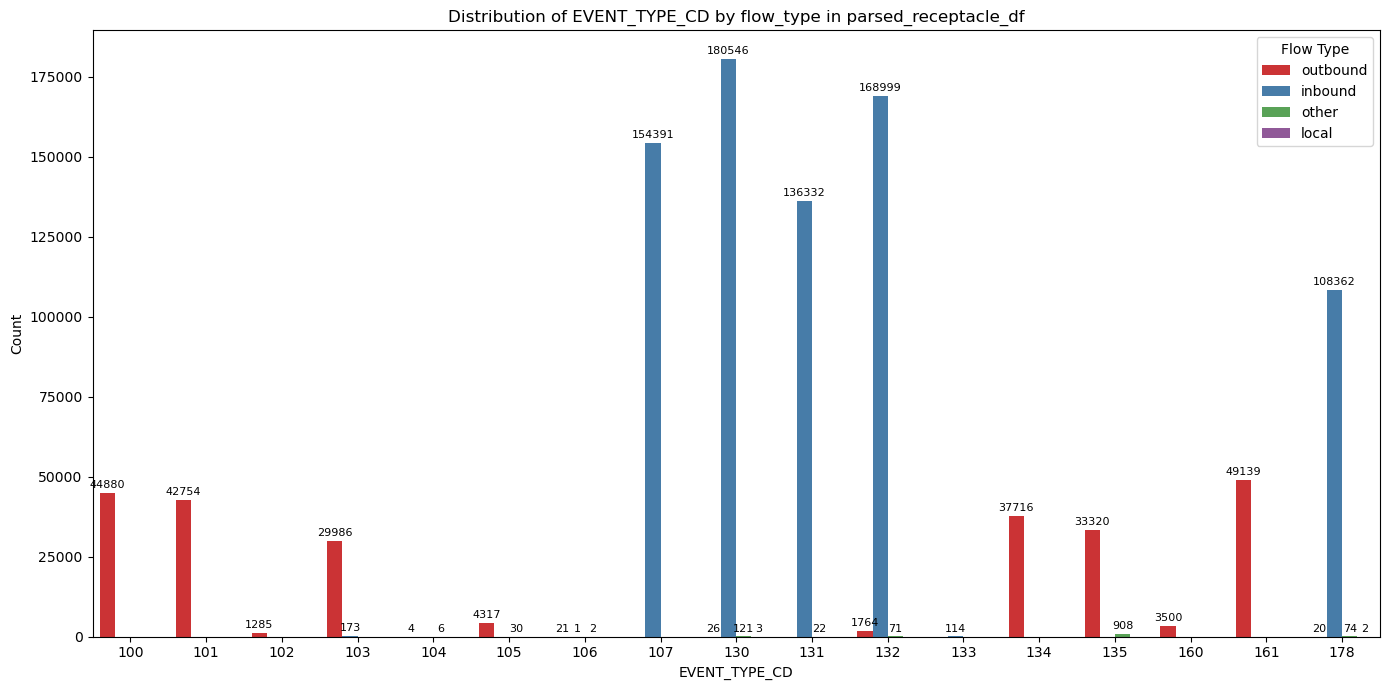

In [ ]:
plt.figure(figsize=(14,7))
ax = sns.countplot(data=parsed_receptacle_df, x="EVENT_TYPE_CD", hue="flow_type", palette='Set1')
plt.title("Distribution of EVENT_TYPE_CD by flow_type in parsed_receptacle_df")
plt.xlabel("EVENT_TYPE_CD")
plt.ylabel("Count")
plt.legend(title="Flow Type")
plt.tight_layout()

for c in ax.containers:
    ax.bar_label(c, label_type='edge', fontsize=8, padding=2)

plt.show()


we can see that there are major event types related to the inbound flow type( coming to DZ)

# Track multiple receptacles just to see the flow of events


--- Events for RECPTCL_FID: AEDXBADZAAEDACN45001001100219 ---


,RECPTCL_FID,date,EVENT_TYPE_CD,etablissement_postal,next_etablissement_postal
0,AEDXBADZAAEDACN45001001100219,2024-07-24 22:40:00.000,107,ETAB_0001,ETAB_0030
1,AEDXBADZAAEDACN45001001100219,2024-07-26 16:18:34.623,130,ETAB_0002,ETAB_0003
2,AEDXBADZAAEDACN45001001100219,2024-07-26 16:23:22.207,132,ETAB_0002,ETAB_0003
3,AEDXBADZAAEDACN45001001100219,2024-07-28 13:04:36.387,132,ETAB_0003,ETAB_0033



--- Events for RECPTCL_FID: AEDXBADZAAEDACN45002001100075 ---


,RECPTCL_FID,date,EVENT_TYPE_CD,etablissement_postal,next_etablissement_postal
0,AEDXBADZAAEDACN45002001100075,2024-07-27 22:40:00.000,107,ETAB_0001,ETAB_0030
1,AEDXBADZAAEDACN45002001100075,2024-07-28 15:48:40.283,130,ETAB_0002,ETAB_0003
2,AEDXBADZAAEDACN45002001100075,2024-07-28 15:59:01.350,132,ETAB_0002,ETAB_0003
3,AEDXBADZAAEDACN45002001100075,2024-07-30 09:42:01.093,103,ETAB_0003,ETAB_0033



--- Events for RECPTCL_FID: AEDXBADZAAEDACN45003001100123 ---


,RECPTCL_FID,date,EVENT_TYPE_CD,etablissement_postal,next_etablissement_postal
0,AEDXBADZAAEDACN45003001100123,2024-07-29 15:09:53.093,130,ETAB_0002,ETAB_0001
1,AEDXBADZAAEDACN45003001100123,2024-07-29 15:12:43.660,132,ETAB_0002,ETAB_0003
2,AEDXBADZAAEDACN45003001100123,2024-07-30 08:45:00.000,107,ETAB_0001,ETAB_0030
3,AEDXBADZAAEDACN45003001100123,2024-07-30 09:41:09.840,103,ETAB_0003,ETAB_0033



--- Events for RECPTCL_FID: AEDXBADZAAEDACN45004001100073 ---


,RECPTCL_FID,date,EVENT_TYPE_CD,etablissement_postal,next_etablissement_postal
0,AEDXBADZAAEDACN45004001100073,2024-07-29 15:09:40.170,130,ETAB_0002,ETAB_0001
1,AEDXBADZAAEDACN45004001100073,2024-07-29 15:12:31.177,132,ETAB_0002,ETAB_0003
2,AEDXBADZAAEDACN45004001100073,2024-07-30 08:45:00.000,107,ETAB_0001,ETAB_0030
3,AEDXBADZAAEDACN45004001100073,2024-07-30 09:42:18.070,103,ETAB_0003,ETAB_0033



--- Events for RECPTCL_FID: AEDXBADZAAEDACN45005001100107 ---


,RECPTCL_FID,date,EVENT_TYPE_CD,etablissement_postal,next_etablissement_postal
0,AEDXBADZAAEDACN45005001100107,2024-07-31 08:45:00.000,107,ETAB_0001,ETAB_0030
1,AEDXBADZAAEDACN45005001100107,2024-08-01 13:24:48.073,130,ETAB_0002,ETAB_0003
2,AEDXBADZAAEDACN45005001100107,2024-08-01 13:37:18.410,132,ETAB_0002,ETAB_0003
3,AEDXBADZAAEDACN45005001100107,2024-08-13 13:55:44.133,132,ETAB_0003,ETAB_0033


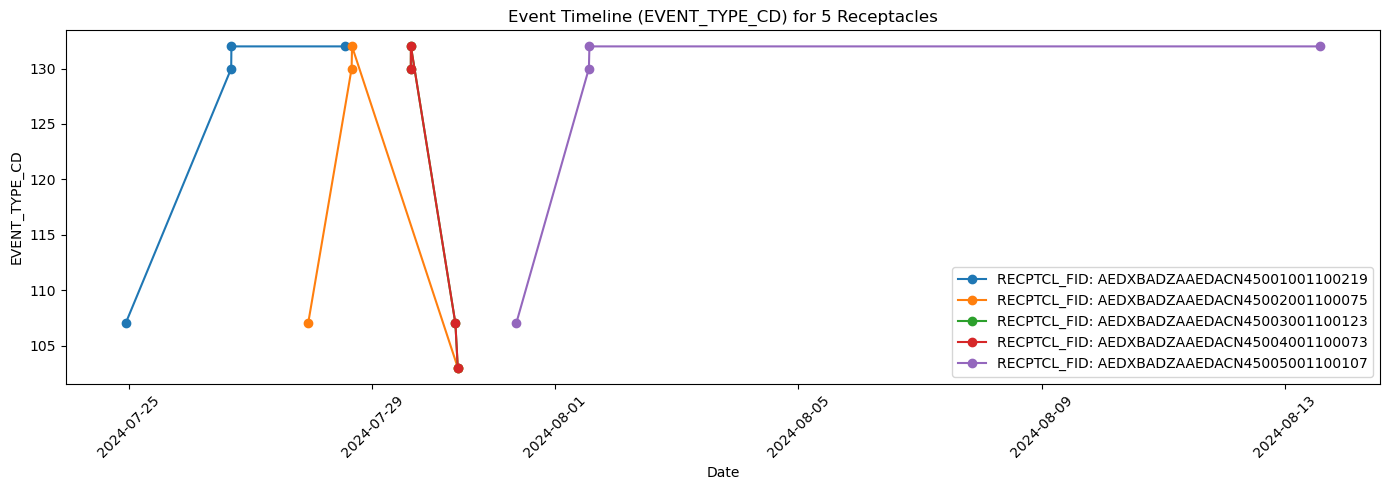

In [ ]:
# Track multiple receptacles: visualize all events for 5 different RECPTCL_FID in parsed_receptacle_df
# Pick 5 unique RECPTCL_FID values to demonstrate
num_examples = 5
example_receptacle_ids = parsed_receptacle_df['RECPTCL_FID'].drop_duplicates().iloc[:num_examples]
for rid in example_receptacle_ids:
    print("\n--- Events for RECPTCL_FID:", rid, "---")
    display(parsed_receptacle_df[parsed_receptacle_df['RECPTCL_FID'] == rid][['RECPTCL_FID', 'date', 'EVENT_TYPE_CD', 'etablissement_postal', 'next_etablissement_postal']].sort_values('date').reset_index(drop=True))


plt.figure(figsize=(14, 5))

for i, receptacle_id in enumerate(example_receptacle_ids):
    ex_df = parsed_receptacle_df[parsed_receptacle_df['RECPTCL_FID'] == receptacle_id].sort_values('date')
    plt.plot(
        ex_df['date'],
        ex_df['EVENT_TYPE_CD'],
        marker='o',
        label=f"RECPTCL_FID: {receptacle_id}"
    )

plt.xticks(rotation=45)
plt.title(f"Event Timeline (EVENT_TYPE_CD) for {num_examples} Receptacles")
plt.xlabel("Date")
plt.ylabel("EVENT_TYPE_CD")
plt.tight_layout()
plt.legend()
plt.show()


# calculating the time of existence for each receptacle/ package 
   ## processing_duration 
   Note : this duration is calculated between min and make date and doesn't give the exact duration since it is not suming the duration between each event
   further analysis could be conducted to take that ninto consideration

### 1. parsed_packages_df

In [ ]:
# Calculate processing_duration (time from first to last event per MAILITM_FID)
# For each mail item, sort events by date, get min and max date per mail item
pkg_duration_df = (
    parsed_packages_df
    .sort_values(['MAILITM_FID', 'date'])
    .groupby('MAILITM_FID')['date']
    .agg(['min', 'max'])
    .reset_index()
)
pkg_duration_df.columns = ['MAILITM_FID', 'min_date', 'max_date']
pkg_duration_df['processing_duration'] = pkg_duration_df['max_date'] - pkg_duration_df['min_date']

# Merge 'processing_duration' back to parsed_packages_df
parsed_packages_df = parsed_packages_df.merge(
    pkg_duration_df[['MAILITM_FID', 'processing_duration']],
    on='MAILITM_FID',
    how='left'
)


display results

In [ ]:

# Display processing_duration statistics
print(parsed_packages_df[['MAILITM_FID', 'date', 'processing_duration']].drop_duplicates(subset=['processing_duration']).head(10))
#print the max value of processing_duration
max_duration = parsed_packages_df['processing_duration'].max()
#print the mail item(s) with the max processing_duration
max_duration_items = parsed_packages_df[parsed_packages_df['processing_duration'] == max_duration]['MAILITM_FID'].unique()
print(f"\nMaximum processing duration: {max_duration}")
print(f"Mail item(s) with maximum processing duration: {max_duration_items}")

#print the min value of processing_duration
min_duration = parsed_packages_df['processing_duration'].min()
#print the mail item(s) with the min processing_duration
min_duration_items = parsed_packages_df[parsed_packages_df['processing_duration'] == min_duration]['MAILITM_FID'].unique()
print(f"\nMinimum processing duration: {min_duration}")
print(f"Mail item(s) with minimum processing duration: {min_duration_items}")

      MAILITM_FID                    date     processing_duration
0   1A19519403783 2023-03-13 07:19:09.307  1 days 05:01:52.286000
6   1A19542788895 2023-02-28 13:34:27.627 14 days 01:16:34.240000
14  1A19566112133 2023-03-02 07:42:59.863 16 days 02:15:45.474000
24  1A20405590128 2023-05-13 09:20:20.703 91 days 21:47:08.614000
29  1A20432066658 2023-08-22 07:44:28.080  2 days 02:34:19.087000
33  1A20456042676 2023-07-22 15:03:14.937  2 days 22:33:17.583000
37  1A20574914770 2024-12-12 11:37:02.967  1 days 21:00:02.033000
49  1A20632305502 2023-03-18 07:55:51.900  1 days 06:05:05.620000
54  1A20984684515 2024-12-21 11:37:04.323 18 days 23:45:08.197000
58  2C17064464709 2023-03-02 07:43:04.220  5 days 08:03:41.583000

Maximum processing duration: 1592 days 05:09:39.563000
Mail item(s) with maximum processing duration: ['CG016096029DE']

Minimum processing duration: 0 days 00:00:00
Mail item(s) with minimum processing duration: ['AP248982997MA' 'AP264403317MA' 'AR872230606MA' ... 'LZ8185

visualization of the distribution of the packages according to the processing duration 

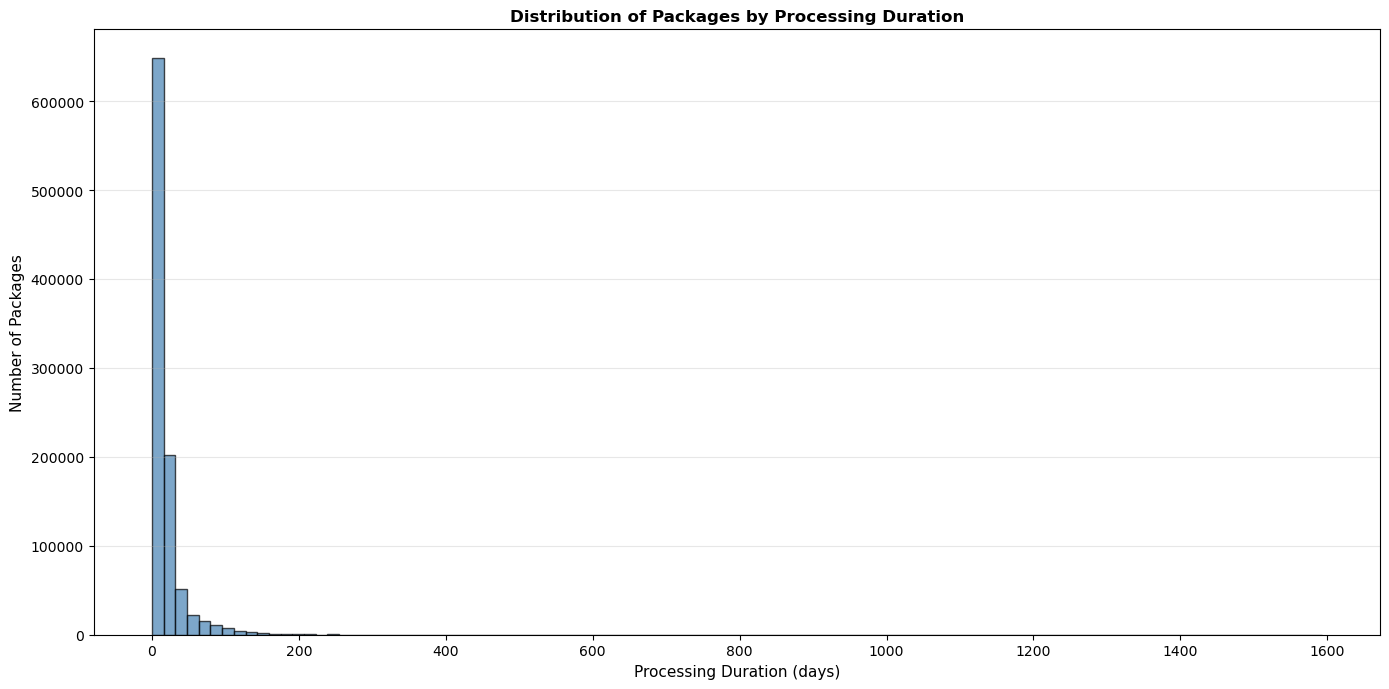

Processing Duration Statistics:
Mean: 19.26 days
Median: 12.00 days
Std Dev: 27.30 days
Min: 0.00 days
Max: 1592.22 days


In [ ]:
# Visualize the distribution of packages by processing_duration
plt.figure(figsize=(14, 7))

# Convert processing_duration to total days for better visualization
parsed_packages_df['processing_duration_days'] = parsed_packages_df['processing_duration'].dt.total_seconds() / (24 * 3600)

# Create histogram
plt.hist(parsed_packages_df['processing_duration_days'], bins=100, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Processing Duration (days)', fontsize=11)
plt.ylabel('Number of Packages', fontsize=11)
plt.title('Distribution of Packages by Processing Duration', fontsize=12, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print("Processing Duration Statistics:")
print(f"Mean: {parsed_packages_df['processing_duration_days'].mean():.2f} days")
print(f"Median: {parsed_packages_df['processing_duration_days'].median():.2f} days")
print(f"Std Dev: {parsed_packages_df['processing_duration_days'].std():.2f} days")
print(f"Min: {parsed_packages_df['processing_duration_days'].min():.2f} days")
print(f"Max: {parsed_packages_df['processing_duration_days'].max():.2f} days")

- This doesn't give a lot of insights, we try to analyse the event type and the duration 

Processing Duration Statistics by EVENT_TYPE_CD:
                  count       mean         std        min        25%  \
EVENT_TYPE_CD                                                          
1                 467.0  23.469882   30.292610   0.850024   7.738786   
2              124527.0  20.391641   27.958997   0.877708   8.910903   
3                3114.0  60.347700   60.252293   0.001011  25.058138   
5                  13.0   7.991350    5.321381   4.140909   4.267736   
6                  24.0  17.622607   17.803029  13.124718  13.125138   
7                 132.0  29.245234   23.020408   7.055215  15.474504   
8                4041.0  57.736659   60.308169   0.001011  22.088660   
9                  21.0  27.431243   23.271320   7.063491  13.181425   
11               3721.0  17.402256   21.403791   2.040416  10.000076   
12              87123.0  19.150478   24.275866   0.000000   8.788216   
30             109706.0  18.611776   26.777245   0.000000   7.689020   
31             

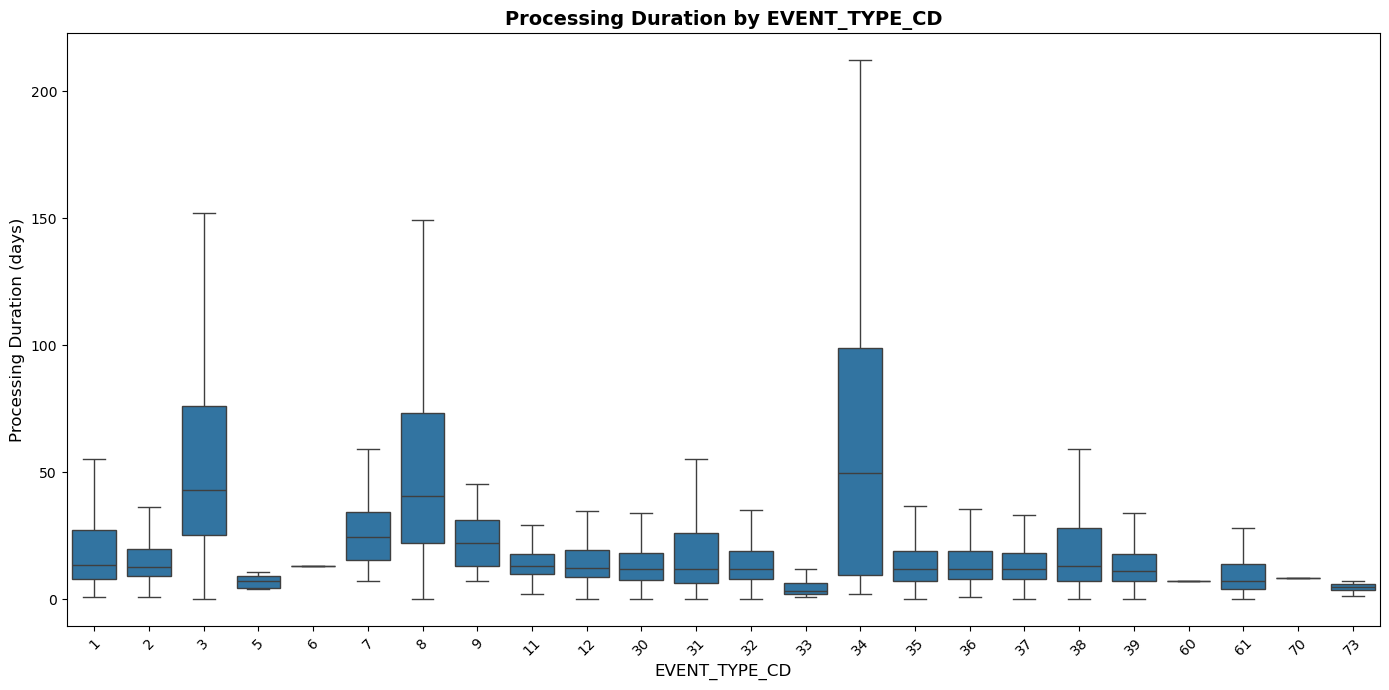

In [ ]:
# Summary statistics for processing_duration by EVENT_TYPE_CD
duration_by_event = (
    parsed_packages_df
    .groupby("EVENT_TYPE_CD")['processing_duration_days']
    .describe()
)
print("Processing Duration Statistics by EVENT_TYPE_CD:")
print(duration_by_event)
print("\n")

# Visualize boxplot of processing_duration by EVENT_TYPE_CD
plt.figure(figsize=(14, 7))
sns.boxplot(x='EVENT_TYPE_CD', y='processing_duration_days', data=parsed_packages_df, showfliers=False)
plt.title('Processing Duration by EVENT_TYPE_CD', fontsize=14, fontweight='bold')
plt.xlabel('EVENT_TYPE_CD', fontsize=12)
plt.ylabel('Processing Duration (days)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Bar chart showing mean processing_duration by EVENT_TYPE_CD

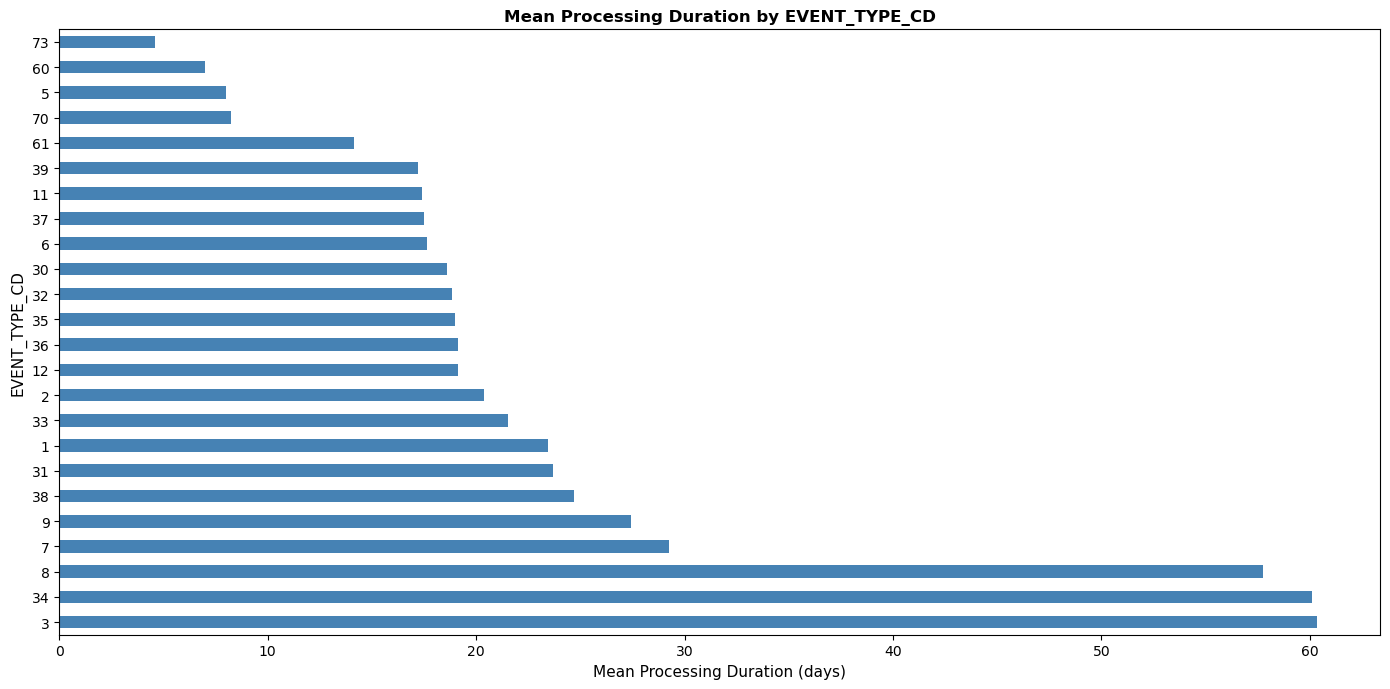

In [ ]:
mean_duration_by_event = parsed_packages_df.groupby('EVENT_TYPE_CD')['processing_duration_days'].mean().sort_values(ascending=False)
plt.figure(figsize=(14, 7))
mean_duration_by_event.plot(kind='barh', color='steelblue')
plt.xlabel('Mean Processing Duration (days)', fontsize=11)
plt.ylabel('EVENT_TYPE_CD', fontsize=11)
plt.title('Mean Processing Duration by EVENT_TYPE_CD', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


now we can see that some events type is a kind of groups of similar event types that have approximatly the same average number of processing duration 

## 2. parsed_receptacle_df

In [ ]:
# Calculate processing_duration (time from first to last event per RECPTCL_FID)
# For each receptacle, sort events by date, get min and max date per receptacle
rec_duration_df = (
    parsed_receptacle_df
    .sort_values(['RECPTCL_FID', 'date'])
    .groupby('RECPTCL_FID')['date']
    .agg(['min', 'max'])
    .reset_index()
)
rec_duration_df['processing_duration'] = rec_duration_df['max'] - rec_duration_df['min']

# Merge 'processing_duration' back to parsed_receptacle_df
parsed_receptacle_df = parsed_receptacle_df.merge(
    rec_duration_df[['RECPTCL_FID', 'processing_duration']],
    on='RECPTCL_FID',
    how='left'
)
# Display the first few rows to show the obtained processing_duration values
print(parsed_receptacle_df[['RECPTCL_FID', 'date', 'processing_duration']].head(10))



                     RECPTCL_FID                    date  \
0  AEDXBADZAAEDACN45001001100219 2024-07-24 22:40:00.000   
1  AEDXBADZAAEDACN45001001100219 2024-07-26 16:18:34.623   
2  AEDXBADZAAEDACN45001001100219 2024-07-26 16:23:22.207   
3  AEDXBADZAAEDACN45001001100219 2024-07-28 13:04:36.387   
4  AEDXBADZAAEDACN45002001100075 2024-07-27 22:40:00.000   
5  AEDXBADZAAEDACN45002001100075 2024-07-28 15:48:40.283   
6  AEDXBADZAAEDACN45002001100075 2024-07-28 15:59:01.350   
7  AEDXBADZAAEDACN45002001100075 2024-07-30 09:42:01.093   
8  AEDXBADZAAEDACN45003001100123 2024-07-29 15:09:53.093   
9  AEDXBADZAAEDACN45003001100123 2024-07-29 15:12:43.660   

     processing_duration  
0 3 days 14:24:36.387000  
1 3 days 14:24:36.387000  
2 3 days 14:24:36.387000  
3 3 days 14:24:36.387000  
4 2 days 11:02:01.093000  
5 2 days 11:02:01.093000  
6 2 days 11:02:01.093000  
7 2 days 11:02:01.093000  
8 0 days 18:31:16.747000  
9 0 days 18:31:16.747000  


### Analysis of the relation between the processing duration and the event type 

Processing Duration Statistics by EVENT_TYPE_CD:
                  count        mean         std       min        25%  \
EVENT_TYPE_CD                                                          
100             44880.0  111.497816  161.276444  0.000000  46.709321   
101             42754.0  120.423349  166.583823  0.000000  52.552397   
102              1285.0  135.840974  359.610454  0.006777  45.846895   
103             30159.0  118.484098  164.009491  0.009304  50.435702   
104                10.0   55.741803   91.316685  2.755626   2.773929   
105              4347.0  152.542869  278.354645  0.000244  39.201476   
106                24.0   56.344763   56.205687  0.017266  30.526709   
107            154391.0  185.026596  264.442130  0.000000  65.846985   
130            180696.0  184.902476  311.758637  0.000000  59.378318   
131            136354.0  190.853910  265.846561  0.000000  67.662929   
132            170834.0  181.081758  312.773263  0.001909  53.807417   
133            

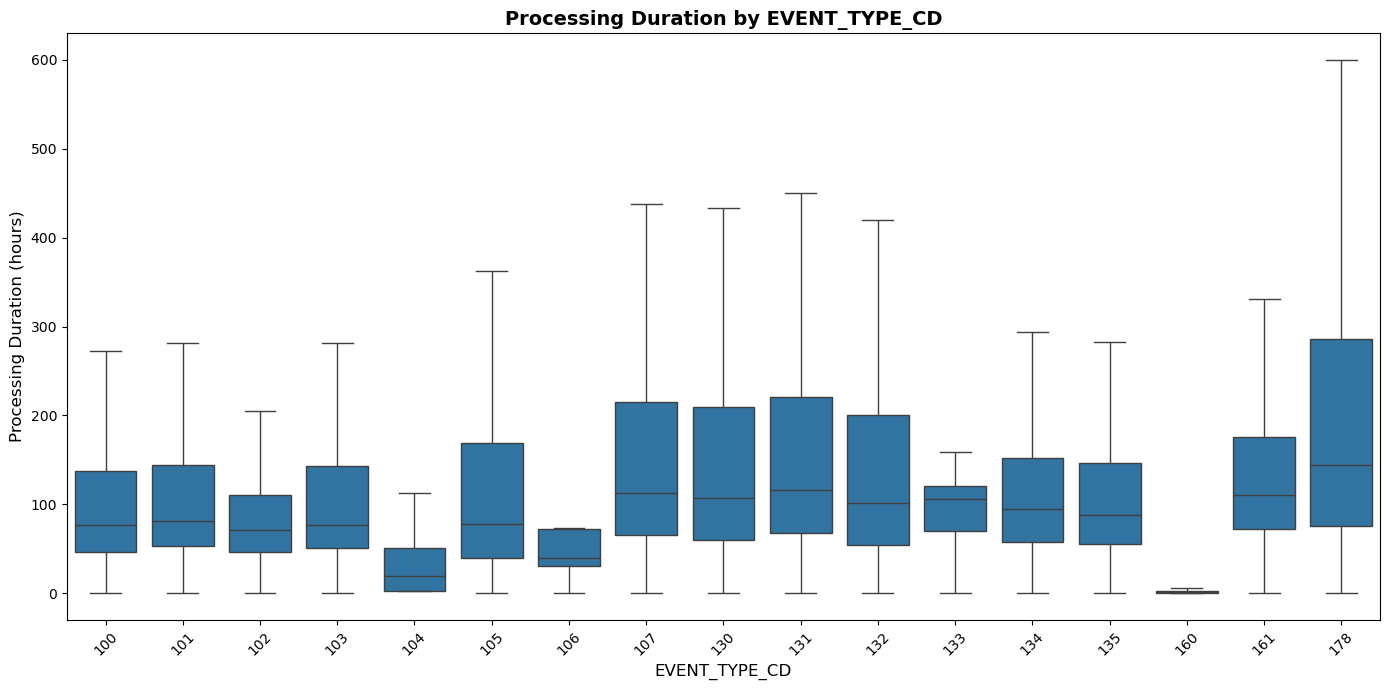

In [ ]:
# Analysis of processing_duration by EVENT_TYPE_CD
parsed_receptacle_df['processing_duration_hours'] = parsed_receptacle_df['processing_duration'].dt.total_seconds() / 3600
# Summary statistics for processing_duration by EVENT_TYPE_CD
duration_by_event = (
    parsed_receptacle_df
    .groupby("EVENT_TYPE_CD")['processing_duration_hours']
    .describe()
)
print("Processing Duration Statistics by EVENT_TYPE_CD:")
print(duration_by_event)
print("\n")


# Visualize boxplot of processing_duration by EVENT_TYPE_CD
plt.figure(figsize=(14, 7))
sns.boxplot(x='EVENT_TYPE_CD', y='processing_duration_hours', data=parsed_receptacle_df, showfliers=False)
plt.title('Processing Duration by EVENT_TYPE_CD', fontsize=14, fontweight='bold')
plt.xlabel('EVENT_TYPE_CD', fontsize=12)
plt.ylabel('Processing Duration (hours)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

-  Bar chart showing mean processing_duration by EVENT_TYPE_CD

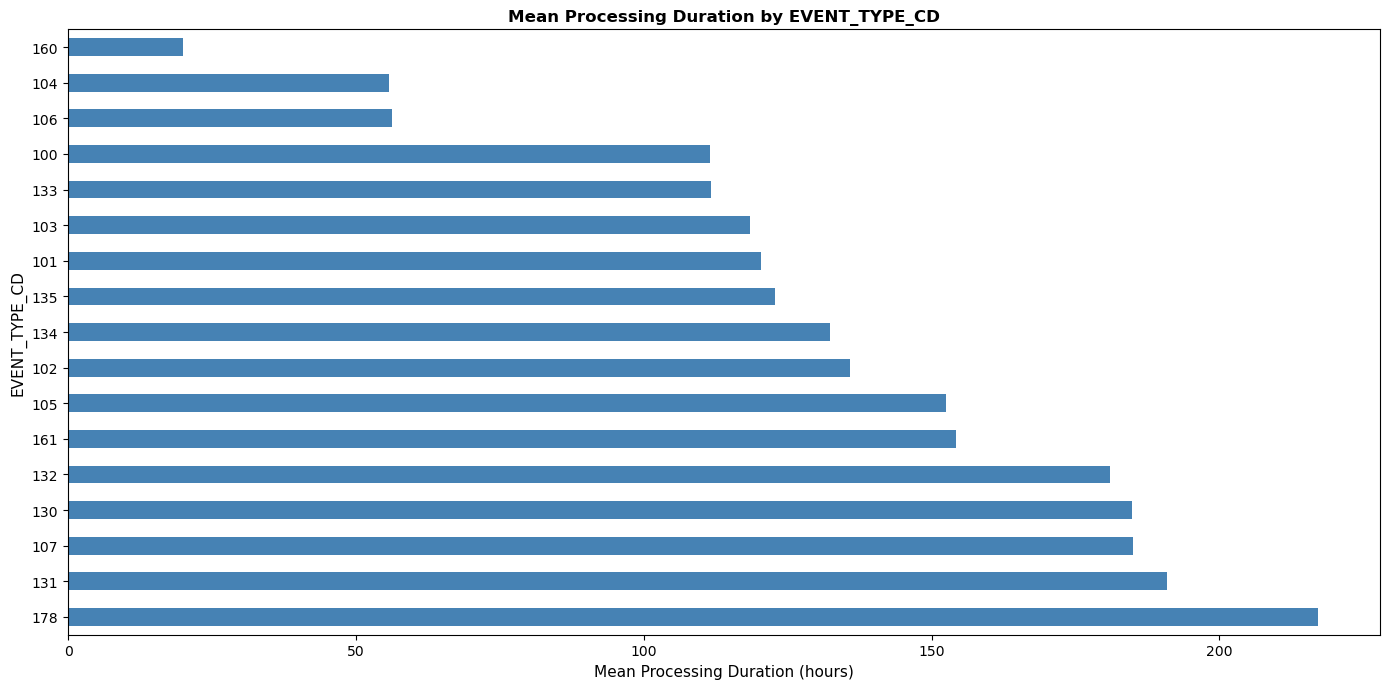

In [ ]:
mean_duration_by_event = parsed_receptacle_df.groupby('EVENT_TYPE_CD')['processing_duration_hours'].mean().sort_values(ascending=False)
plt.figure(figsize=(14, 7))
mean_duration_by_event.plot(kind='barh', color='steelblue')
plt.xlabel('Mean Processing Duration (hours)', fontsize=11)
plt.ylabel('EVENT_TYPE_CD', fontsize=11)
plt.title('Mean Processing Duration by EVENT_TYPE_CD', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()




-  Heatmap: EVENT_TYPE_CD vs Flow Type with mean duration

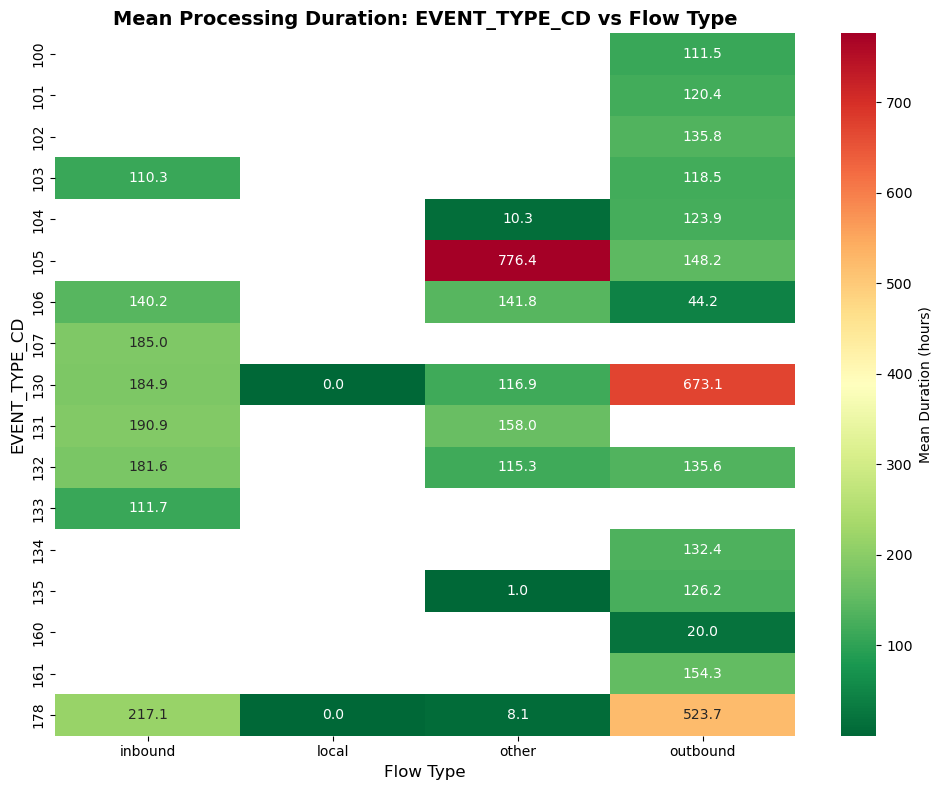

In [ ]:

pivot_table = parsed_receptacle_df.pivot_table(
    values='processing_duration_hours',
    index='EVENT_TYPE_CD',
    columns='flow_type',
    aggfunc='mean'
)
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt='.1f', cmap='RdYlGn_r', cbar_kws={'label': 'Mean Duration (hours)'})
plt.title('Mean Processing Duration: EVENT_TYPE_CD vs Flow Type', fontsize=14, fontweight='bold')
plt.xlabel('Flow Type', fontsize=12)
plt.ylabel('EVENT_TYPE_CD', fontsize=12)
plt.tight_layout()
plt.show()

- Correlation: Count events per receptacle and duration

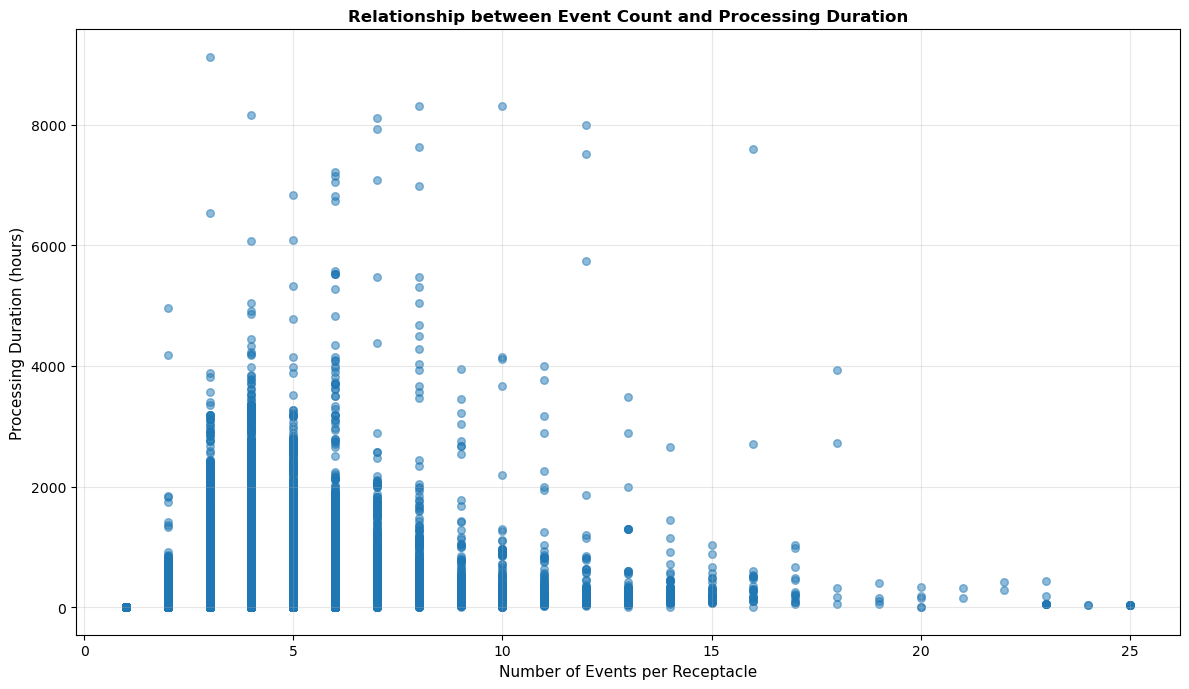


Correlation between event count and processing duration: 0.1629


In [ ]:
event_count_per_receptacle = parsed_receptacle_df.groupby('RECPTCL_FID').size().reset_index(name='event_count')
receptacle_duration = parsed_receptacle_df[['RECPTCL_FID', 'processing_duration_hours']].drop_duplicates()
event_duration_corr = event_count_per_receptacle.merge(receptacle_duration, on='RECPTCL_FID')

plt.figure(figsize=(12, 7))
plt.scatter(event_duration_corr['event_count'], event_duration_corr['processing_duration_hours'], alpha=0.5, s=30)
plt.xlabel('Number of Events per Receptacle', fontsize=11)
plt.ylabel('Processing Duration (hours)', fontsize=11)
plt.title('Relationship between Event Count and Processing Duration', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate correlation coefficient
correlation = event_duration_corr['event_count'].corr(event_duration_corr['processing_duration_hours'])
print(f"\nCorrelation between event count and processing duration: {correlation:.4f}")

we can see that having more events reduces the duration

### Analysis of the relation between the processing_duration and flow_type

            count                       mean                         std  \
flow_type                                                                  
inbound    748918  7 days 21:53:38.387375816  11 days 23:50:30.013191257   
local           5     0 days 00:00:00.004200   0 days 00:00:00.003834057   
other        1234  1 days 17:16:08.395106158  11 days 09:38:34.820086805   
outbound   248732  5 days 07:12:13.243650736   7 days 05:15:26.387532984   

                       min                     25%                     50%  \
flow_type                                                                    
inbound    0 days 00:00:00  2 days 17:45:46.993000  4 days 18:53:46.477000   
local      0 days 00:00:00         0 days 00:00:00  0 days 00:00:00.007000   
other      0 days 00:00:00         0 days 00:00:00         0 days 00:00:00   
outbound   0 days 00:00:00  2 days 05:50:58.037000  3 days 15:46:34.163000   

                              75%                       max  
flow_type   

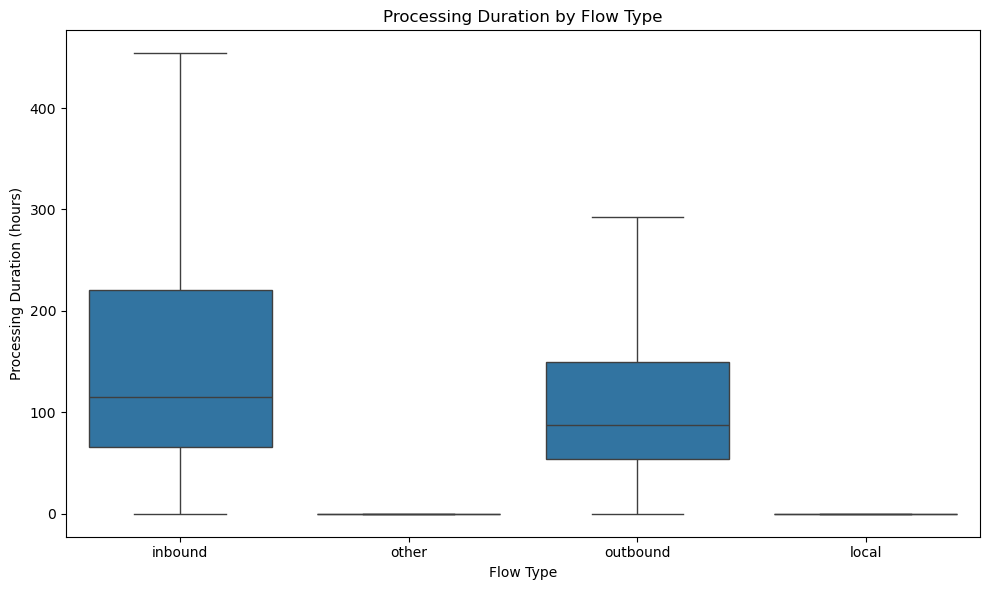

In [ ]:
# We'll analyze the relationship between processing_duration and flow_type .

duration_by_flow = (
    parsed_receptacle_df
    .groupby("flow_type")['processing_duration']
    .describe()
)
print(duration_by_flow)

# Visualize the distribution: boxplot of processing_duration by flow_type

# Convert processing_duration to total hours for visualization
#parsed_receptacle_df['processing_duration_hours'] = parsed_receptacle_df['processing_duration'].dt.total_seconds() / 3600

plt.figure(figsize=(10,6))
sns.boxplot(x='flow_type', y='processing_duration_hours', data=parsed_receptacle_df, showfliers=False)

plt.title('Processing Duration by Flow Type')
plt.xlabel('Flow Type')
plt.ylabel('Processing Duration (hours)')
plt.tight_layout()
plt.show()


From this boxplot of Processing Duration by Flow Type, we can extract several clear results and insights:

1. Inbound flow

Highest processing times overall

Median is relatively high (around ~110–120 hours)

Very wide spread (high variability) → large IQR and long whiskers

Extreme delays exist (outliers reaching ~450+ hours)

2. Outbound flow

Moderate processing time

Median lower than inbound (~80–90 hours)

Still variable, but less extreme than inbound

Some long delays, but fewer and smaller than inbound


3. Local flow

Very low processing duration

Tight distribution (low variance)

Almost no outliers

Local receptacles are processed quickly and consistently.

4. Other flow

Near-zero processing duration

Almost no variability

### Show the row with the max value of processing_duration

In [ ]:
max_row = rec_duration_df.loc[rec_duration_df['processing_duration'].idxmax()]
print(max_row)


RECPTCL_FID            FRCDGADZALGAAEN99999999990102
min                       2024-03-03 08:22:21.997000
max                       2025-03-18 10:56:03.800000
processing_duration         380 days 02:33:41.803000
Name: 185042, dtype: object


In [ ]:
rows = parsed_receptacle_df.loc[parsed_receptacle_df['RECPTCL_FID'] == 'FRCDGADZALGAAEN99999999990102', ['RECPTCL_FID', 'date']]
print(rows)


                          RECPTCL_FID                    date
874013  FRCDGADZALGAAEN99999999990102 2024-03-03 08:22:21.997
874014  FRCDGADZALGAAEN99999999990102 2024-03-03 08:25:27.657
874015  FRCDGADZALGAAEN99999999990102 2025-03-18 10:56:03.800


this is probably an error in the typing since they are the only values existing of the receptacle and the three are from march the diff is in the year of the third

# extracting more features

## receptacle dataset

intuitively we think that the number of etablissement crossed by the receptacle can affect the processing duration

In [ ]:
#calculate the number of unique etablissement crossed by each receptacle
etab_counts = (
    parsed_receptacle_df
    .groupby('RECPTCL_FID')['etablissement_postal']
    .nunique()
    .reset_index()
    .rename(columns={'etablissement_postal': 'num_etablissements'})
)
# Merge back to parsed_receptacle_df
parsed_receptacle_df = parsed_receptacle_df.merge(
    etab_counts,
    on='RECPTCL_FID',
    how='left'
)

parsed_receptacle_df.head(10)

,Unnamed: 0,RECPTCL_FID,date,etablissement_postal,EVENT_TYPE_CD,next_etablissement_postal,origin_country,destination_country,origin_destination,flow_type,processing_duration,processing_duration_hours,num_etablissements
0,0,AEDXBADZAAEDACN45001001100219,2024-07-24 22:40:00.000,ETAB_0001,107,ETAB_0030,AE,DZ,AE_DZ,inbound,3 days 14:24:36.387000,86.410107,3
1,1,AEDXBADZAAEDACN45001001100219,2024-07-26 16:18:34.623,ETAB_0002,130,ETAB_0003,AE,DZ,AE_DZ,inbound,3 days 14:24:36.387000,86.410107,3
2,2,AEDXBADZAAEDACN45001001100219,2024-07-26 16:23:22.207,ETAB_0002,132,ETAB_0003,AE,DZ,AE_DZ,inbound,3 days 14:24:36.387000,86.410107,3
3,3,AEDXBADZAAEDACN45001001100219,2024-07-28 13:04:36.387,ETAB_0003,132,ETAB_0033,AE,DZ,AE_DZ,inbound,3 days 14:24:36.387000,86.410107,3
4,4,AEDXBADZAAEDACN45002001100075,2024-07-27 22:40:00.000,ETAB_0001,107,ETAB_0030,AE,DZ,AE_DZ,inbound,2 days 11:02:01.093000,59.033637,3
5,5,AEDXBADZAAEDACN45002001100075,2024-07-28 15:48:40.283,ETAB_0002,130,ETAB_0003,AE,DZ,AE_DZ,inbound,2 days 11:02:01.093000,59.033637,3
6,6,AEDXBADZAAEDACN45002001100075,2024-07-28 15:59:01.350,ETAB_0002,132,ETAB_0003,AE,DZ,AE_DZ,inbound,2 days 11:02:01.093000,59.033637,3
7,7,AEDXBADZAAEDACN45002001100075,2024-07-30 09:42:01.093,ETAB_0003,103,ETAB_0033,AE,DZ,AE_DZ,inbound,2 days 11:02:01.093000,59.033637,3
8,8,AEDXBADZAAEDACN45003001100123,2024-07-29 15:09:53.093,ETAB_0002,130,ETAB_0001,AE,DZ,AE_DZ,inbound,0 days 18:31:16.747000,18.521319,3
9,9,AEDXBADZAAEDACN45003001100123,2024-07-29 15:12:43.660,ETAB_0002,132,ETAB_0003,AE,DZ,AE_DZ,inbound,0 days 18:31:16.747000,18.521319,3


In [ ]:
#calculate the correlation between num_etablissements and processing_duration
correlation = parsed_receptacle_df[['num_etablissements', 'processing_duration_hours']].corr().iloc[0,1]
print(f"Correlation between number of etablissments and processing duration (hours): {correlation}")

Correlation between number of etablissments and processing duration (hours): 0.13230766081429524


considering the size of the dataset this correlation is not bad

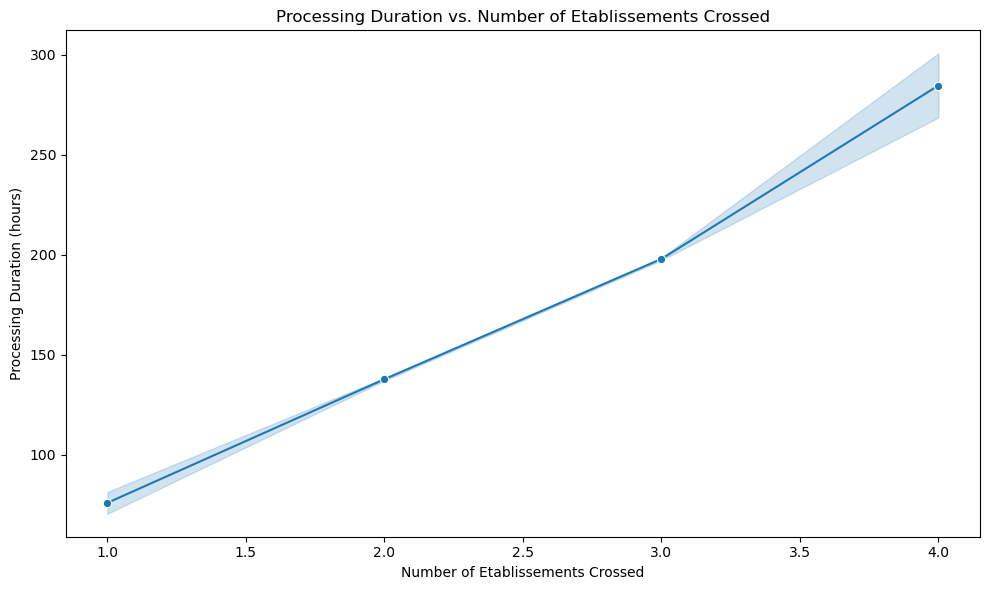

In [ ]:
# Visualize the relationship between num_etablissements and processing_duration
plt.figure(figsize=(10,6))
sns.lineplot(
    data=parsed_receptacle_df,
    x='num_etablissements',
    y='processing_duration_hours',
    marker='o'
)
plt.title('Processing Duration vs. Number of Etablissements Crossed')
plt.xlabel('Number of Etablissements Crossed')
plt.ylabel('Processing Duration (hours)')
plt.tight_layout()
plt.show()

the line plot shows a clear increasing trend indicating that as the number of etablissments crossed increases the processing duration also increases, but the correlation value shows that the relation is weak

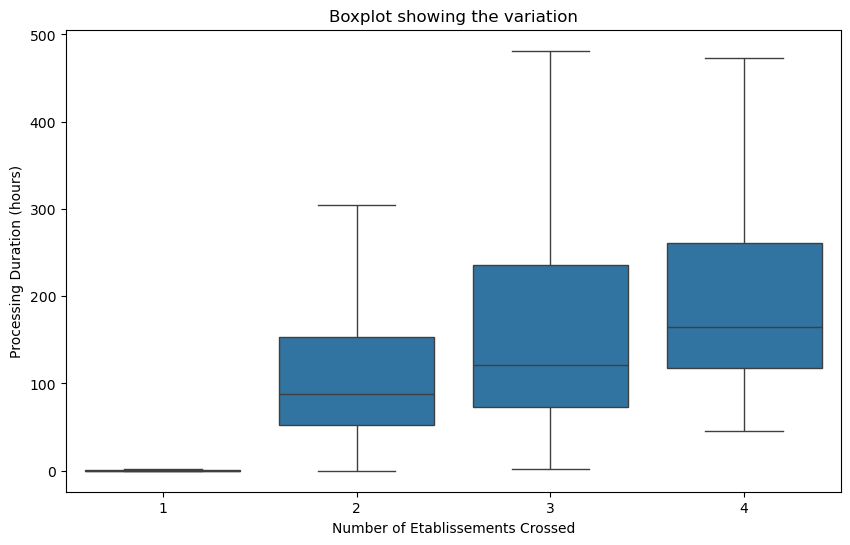

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='num_etablissements', y='processing_duration_hours', data=parsed_receptacle_df, showfliers=False)
plt.xlabel("Number of Etablissements Crossed")
plt.ylabel("Processing Duration (hours)")
plt.title("Boxplot showing the variation")
plt.show()

by looking at the boxplot we can see that the median processing duration increases with the number of etablissments crossed but the variance also increases significantly,this explains the weak correlation value obtained earlier

## packages dataset

we test the same hypothesis for the packages dataset

In [ ]:
#calculate the number of unique etablissement crossed by each package
etab_counts_pkg = (
    parsed_packages_df
    .groupby('MAILITM_FID')['etablissement_postal']
    .nunique()
    .reset_index()
    .rename(columns={'etablissement_postal': 'num_etablissements'})
)
# Merge back to parsed_packages_df
parsed_packages_df = parsed_packages_df.merge(
    etab_counts_pkg,
    on='MAILITM_FID',
    how='left'
)

In [ ]:
#calculate the correlation between num_etablissements and processing_duration
correlation_pkg = parsed_packages_df[['num_etablissements', 'processing_duration_days']].corr().iloc[0,1]
print(f"Correlation between number of etablissments and processing duration (days): {correlation_pkg}")

Correlation between number of etablissments and processing duration (days): 0.11903421488817802


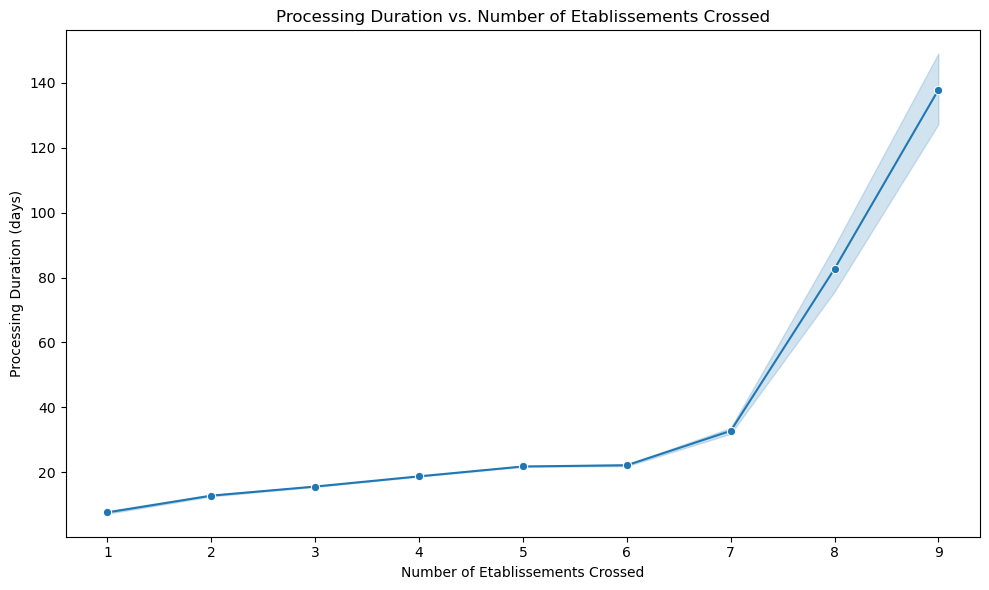

In [ ]:
# Visualize the relationship between num_etablissements and processing_duration
plt.figure(figsize=(10,6))
sns.lineplot(
    data=parsed_packages_df,
    x='num_etablissements',
    y='processing_duration_days',
    marker='o'
)
plt.title('Processing Duration vs. Number of Etablissements Crossed')
plt.xlabel('Number of Etablissements Crossed')
plt.ylabel('Processing Duration (days)')
plt.tight_layout()
plt.show()

the correlation is weaker than that of the receptacle dataset this is probably because of variation in packages types

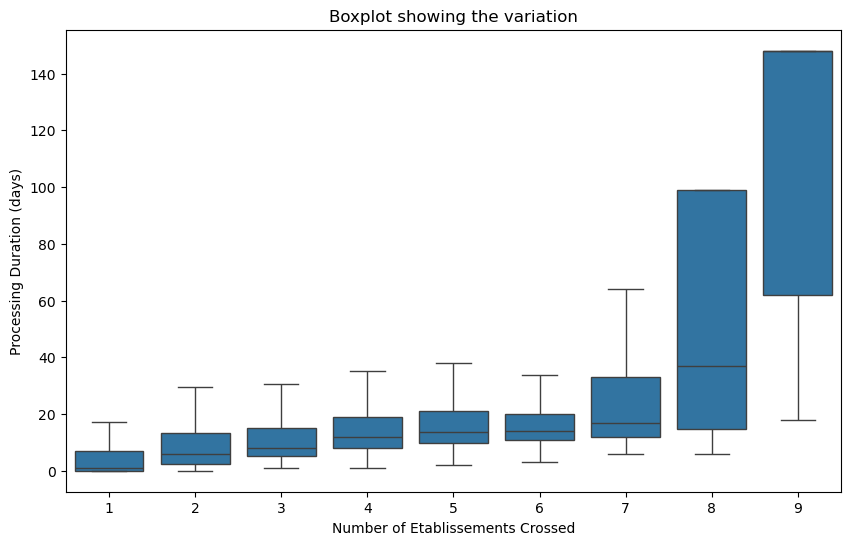

In [ ]:
# Boxplot of processing_duration by num_etablissements
plt.figure(figsize=(10, 6))
sns.boxplot(x='num_etablissements', y='processing_duration_days', data=parsed_packages_df, showfliers=False)
plt.xlabel("Number of Etablissements Crossed")
plt.ylabel("Processing Duration (days)")
plt.title("Boxplot showing the variation")
plt.show()

relation starts to appear more when the number of etablissments crossed is more than 6

## Data Splitting to training and testing sets

- We propose to split datasets (which are already sorted by date) using `TimeSeriesSplit` from `sklearn.model_selection`
- because we need to keep all rows for a specific `MAILITM_FID` as a single block and not separated.
- older rows are kept for the `training_set` and newer ones are kept for the `testing_set`.

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

packages_cat_features = [col for col in parsed_packages_df.column if col.dtype in ['object']]
receptacles_cat_features = [col for col in parsed_receptacle_df.column if col.dtype in ['object']]

packages_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), packages_cat_features)
    ],
    remainder='passthrough'
)

receptacles_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), receptacles_cat_features)
    ],
    remainder='passthrough'
)


# This assumes that the data is sorted by date
# By default, it splits data into 5 folds (Cross-validation)

tscv = TimeSeriesSplit()

In [ ]:
def get_etab_mapping(df):
    # 1. Calculate the global mode once (to use as a safe fallback)
    global_mode = df['next_etablissement_postal'].mode().iat[0]

    # 2. Get the mode for every group at once
    # This creates a Series where index = etablissement, value = most frequent next
    modes_per_group = df.groupby('etablissement_postal')['next_etablissement_postal'].agg(
        lambda x: x.mode().iat[0] if not x.mode().empty else global_mode
    )

    # 3. Convert to dictionary
    etablissement_dict = modes_per_group.to_dict()
    return etablissement_dict

* After splitting, for each pair `(X_train, X_test)` of `packages_splits`, we'll fill the null values of `next_etablissement_postal` based on the most frequent value of `next_etablissement_postal` appearing with the value of `etablissement_postal` of each specific row having a null value in `next_etablissement_postal`
* Example:
say that a row has a null `next_etablissement_postal`, we look at it's `etablissement_postal` value (say `VAL`), we iterate through the training set, we count how many times each `ETAB_XXXX` in ` next_etablissement_postal` appears with `VAL` being in `etablissement_postal`, we take the mode, and we use it fill all rows having null value at `next_etablissement_postal` where their `etablissement_postal` is `VAL`

In [ ]:
def build_splits(preprocessor, df, id_col):
    df = df.sort_values('date')
    unique_ids = df[id_col].unique()
    tscv = TimeSeriesSplit(n_splits=5)
    splits = []

    for train_id_idx, test_id_idx in tscv.split(unique_ids):
        # 1. Get the actual IDs for this fold
        train_ids = unique_ids[train_id_idx]
        test_ids = unique_ids[test_id_idx]
        
        # 2. Filter the main dataframe to get rows
        train_df = df[df[id_col].isin(train_ids)].copy()
        test_df = df[df[id_col].isin(test_ids)].copy()
        
        # 3. Handle NULLS FIRST (using your dictionary logic)
        etablissement_dict = get_etab_mapping(train_df)
        
        for d in [train_df, test_df]:
            mask = d['next_etablissement_postal'].isna()
            d.loc[mask, 'next_etablissement_postal'] = d.loc[mask, 'etablissement_postal'].map(etablissement_dict)
            # Optional: Fill remaining NaNs with global mode if any mapping failed
            d['next_etablissement_postal'] = d['next_etablissement_postal'].fillna(train_df['next_etablissement_postal'].mode()[0])

        # 4. Now that data is clean, Extract Target / Anomaly Detection here if needed
        # ... (Clustering/IsolationForest logic) ...

        # 5. Finally, Transform to Numeric for the Classifier
        X_train = preprocessor.fit_transform(train_df)
        X_test = preprocessor.transform(test_df)
        
        splits.append((X_train, X_test))
        
    return splits

In [ ]:
packages_splits = build_splits(packages_preprocessor, parsed_packages_df, 'MILTITM_FID')
receptacles_splits = build_splits(receptacles_preprocessor, parsed_receptacle_df, 'RECPTCL_FID')

**We still need to deal with the high dimensionality we get from `OneHotEncoder`**

* now each of `packages_splits` and `receptacles_splits` have 5 pairs of `(X_train, X_test)` following the cross-validation method
* for each pair, we'll apply a classification algorithm to predict the clustering and anomaly detection targets for the testing data